In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%reload_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import sys
sys.path.append('../src')

import cv2
from IPython.display import display_html
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import matplotlib.patches as mpatches
from metadata import metadata
import ome_types
import os
import numpy as np
import pandas as pd
from pathlib import Path
from random import sample
import re
# from sklearn.mixture import GaussianMixture
from scikit_posthocs import posthoc_dunn as phd
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

from utils import list_subdir_filter as lsd

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression as lr
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import minmax_scale


md = metadata()
figures_dir = '/projects/ag-bozek/lunaphore/reports/figures'


all_markers = ['ki67', 'slug', 'ccasp', 'c-myc', 'cell_vim', 'cell_ecad']
conditions  = ['wt_ctr', 'wt_TT', 'ko_ctr', 'ko_TT', 'res_ctr', 'res_TT']
to_analyze = ['ki67_mean', 'slug_mean', 'cell_gfp_mean', 'ccasp_mean', 'c-myc_mean', 'cell_ecad_mean', 'cell_vim_mean']


def get_lower_tri_heatmap(df, name):
    '''
    description: todo
    '''
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = 'viridis'#sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(df, mask=mask, cmap=cmap, vmax=1, center=0.5,
            square=True, annot=True, fmt='.4f', linewidths=.5, cbar_kws={"shrink": .5})
    # # save to file
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(figures_dir, name))

    return sns_plot


Load the single cell data for all samples

In [2]:
%%time
pickle_files = lsd(md.folders['regionprops'], False, 'A40_')

all_df = []

for f in pickle_files:
    slide_id = re.sub('.*A40_([0-9]+).*', '\\1', f)
    df_ = pd.read_pickle(f)
    # print(slide_id, np.sum(df_.isna().sum()))
    # print(df_.shape)
    df_['slide_id'] = slide_id
    all_df.append(df_)

df_tot = pd.concat(all_df)

colnames = df_tot.columns.values
marker_names = list(md.markers)[3:]
nuclei_names = [f for f in colnames if not re.search('^cell_', f)]
cell_names = [f for f in colnames if re.search('^cell_', f)]

nuclei_lnames = [re.sub('intensity_([a-z]+)-([0-9]+).*', '\\2.\\1', f).split('.') for f in nuclei_names]
cell_lnames = [re.sub('.*intensity_([a-z]+)-([0-9]+).*', '\\2.\\1', f).split('.') for f in cell_names]

renaming_dict = {n:n for n in colnames}

def do_rename(colname):
    if len(colname) == 2:
        return f'{marker_names[int(colname[0])]}_{colname[1]}'
    else:
        return colname[0]

renaming_dict = {
    **{nuclei_names[i]:do_rename(nuclei_lnames[i]) for i in range(len(nuclei_lnames))},
    **{cell_names[i]:f'cell_{do_rename(cell_lnames[i])}' for i in range(len(cell_lnames))}
}

renaming_dict['cell_centroid-0'] = 'cell_centroid-0'
renaming_dict['cell_centroid-1'] = 'cell_centroid-1'

# REMOVE SLIDE 2427 as per Jenny's request!
df_tot = df_tot.rename(columns=renaming_dict).reset_index(drop=True)
df_tot = df_tot.loc[df_tot.slide_id != '2427']
df_tot = df_tot.loc[df_tot.slide_id != '2397']
df_tot = df_tot.loc[df_tot.slide_id != '2294']
df_tot = df_tot.loc[df_tot.slide_id != '2311']

CPU times: user 2.12 s, sys: 2.09 s, total: 4.21 s
Wall time: 8.33 s


In [3]:
%%time
df_clean = df_tot.dropna()
df_clean.loc[df_clean['slide_id'] == '9429', 'slide_id'] = '2429'
df_clean['slide_id'] = df_clean['slide_id'].astype('category')
slide_ids = df_clean.slide_id.unique()

xfile = pd.read_excel(lsd(md.folders['images'], True, 'xls')[0])
xfile['id_code'] = [re.sub('A40.', '', l) for l in xfile.Identification]
xfile = xfile.loc[xfile['id_code'].isin(slide_ids)].sort_values('id_code')
# pd.read_csv()

condition_dict = {xfile.iloc[i]['id_code']:xfile.iloc[i]['Condition'] for i in range(len(xfile))}
df_clean['condition'] = [condition_dict[f] for f in df_clean['slide_id']]
df_clean['condition'] = df_clean['condition'].astype('category').cat.reorder_categories(conditions, ordered=True)
# df_clean['condition'].astype('category')

df_clean = df_clean.groupby('slide_id', group_keys=False, observed=False).apply(
    lambda g: g[g.cell_gfp_mean < g.cell_gfp_mean.quantile(.95)]
)

df_clean = df_clean.sort_values('condition')

conditions = df_clean.condition.unique()

<timed exec>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


CPU times: user 1.43 s, sys: 720 ms, total: 2.15 s
Wall time: 3.82 s


In [4]:
# not sure we do need all this stuff, but oh well
flierprops = dict(
    marker='.', 
    markerfacecolor='black', 
    alpha=0.6, 
    markersize=4, 
    markeredgecolor='none'
)

meanpointprops = dict(
    marker='.', 
    markerfacecolor='black', 
    markersize=8, 
    markeredgecolor='none'
)

meanlineprops = dict(linewidth=1.5)

medianprops=dict(linewidth = 1.9)

titleargs=dict(
    x=0.037,
    y=1,
    ha='left',
    va='top',
    fontsize=18
)

textargs=dict(
    x=0.05, 
    y=0.95,
    horizontalalignment='left',
    verticalalignment='top', 
    fontsize=16,
    c='black',
    weight='bold'
)

percargs=dict(
    x=0.96, 
    y=0.95,
    horizontalalignment='right',
    verticalalignment='top', 
    fontsize=16,
    c='black',
    weight='normal'
)

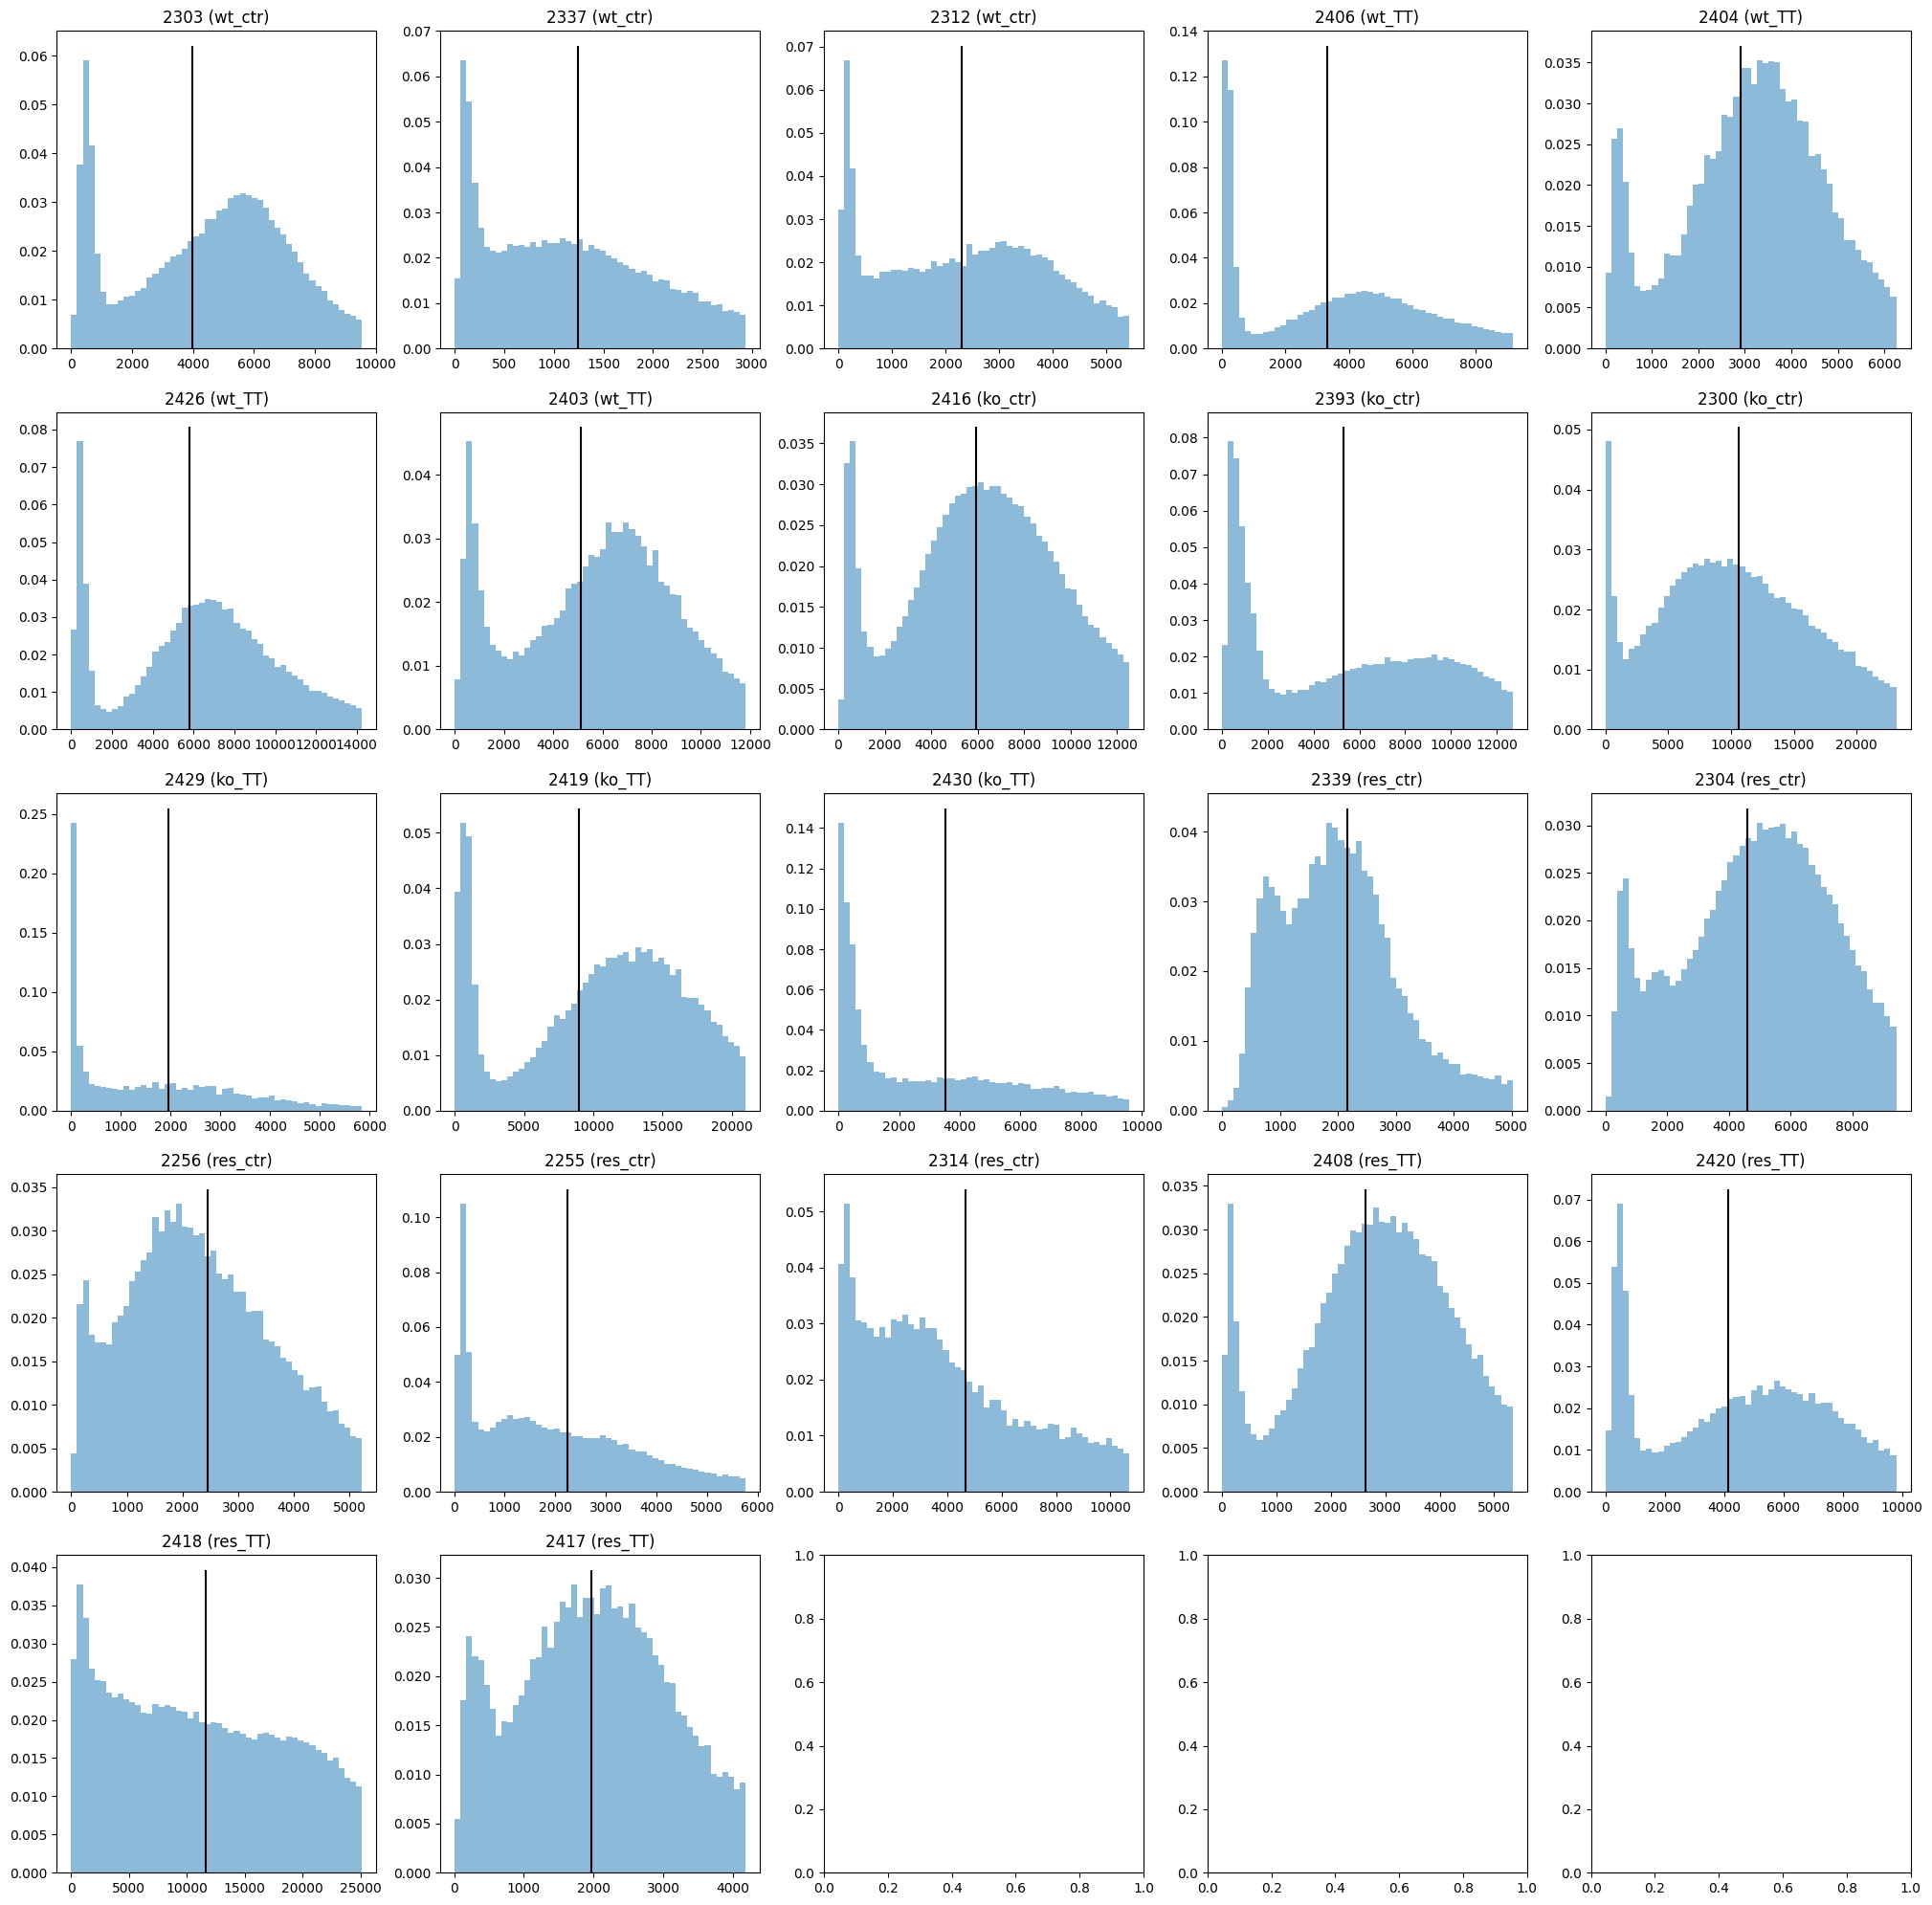

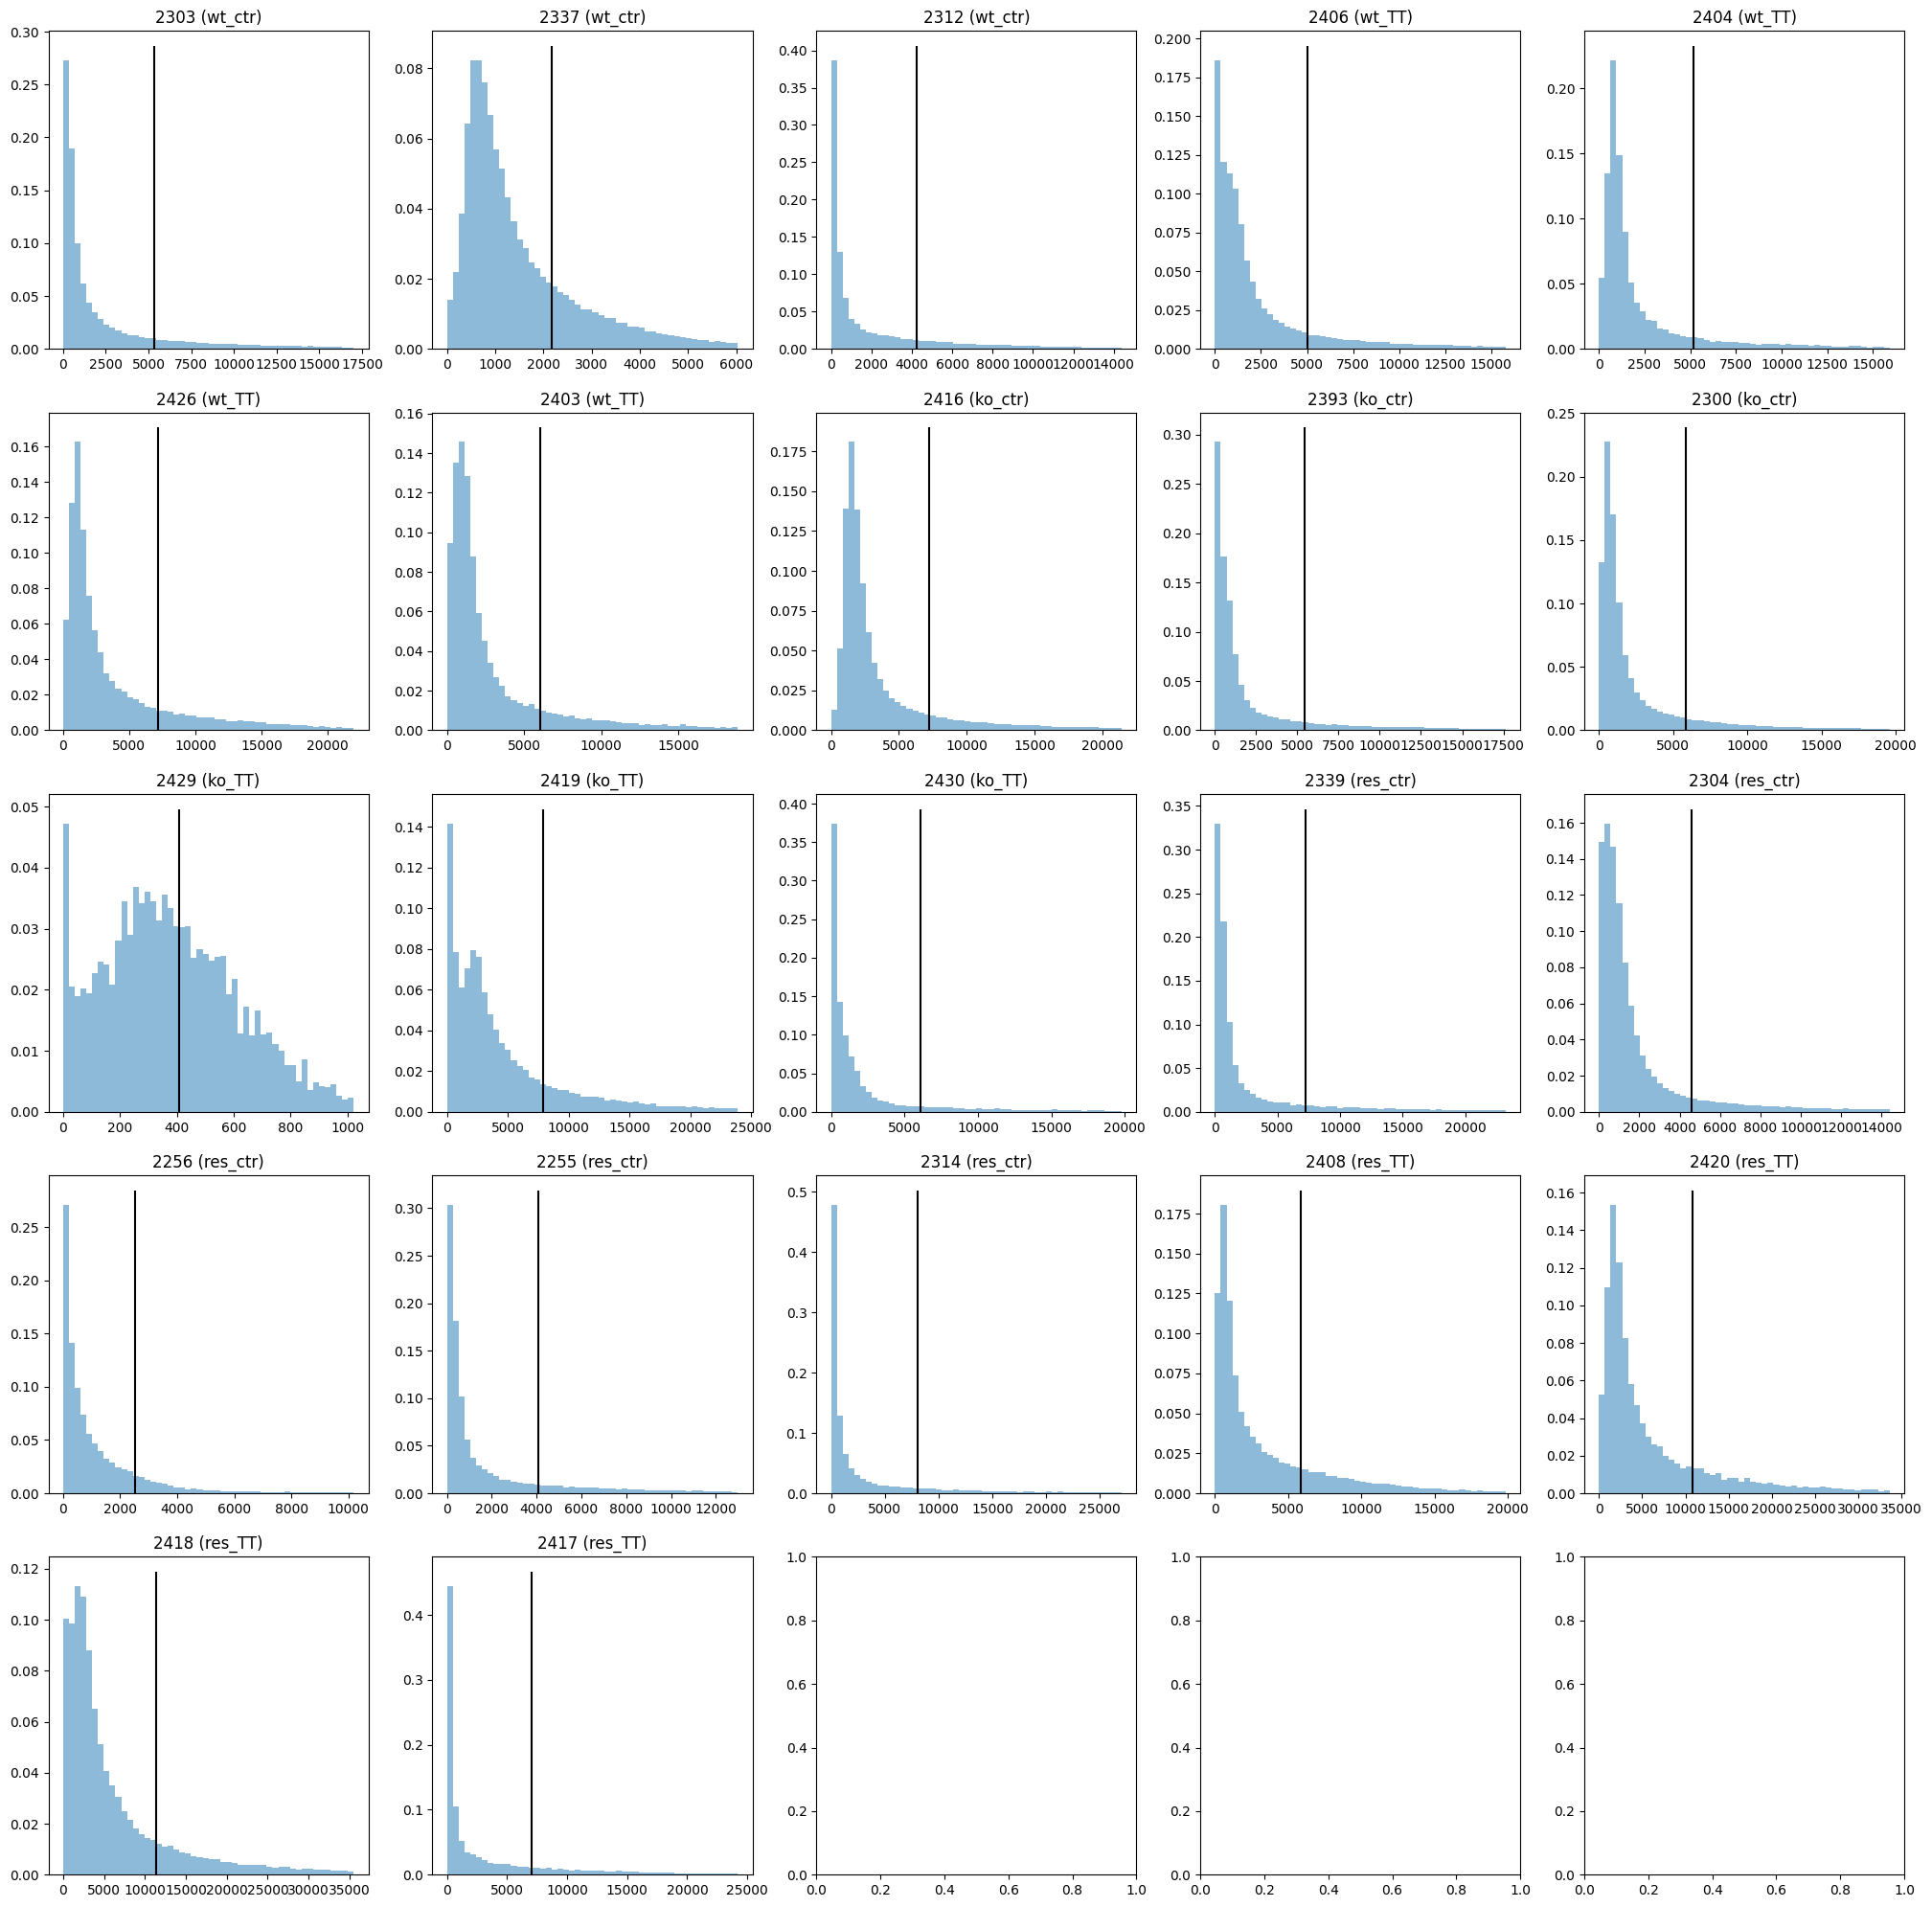

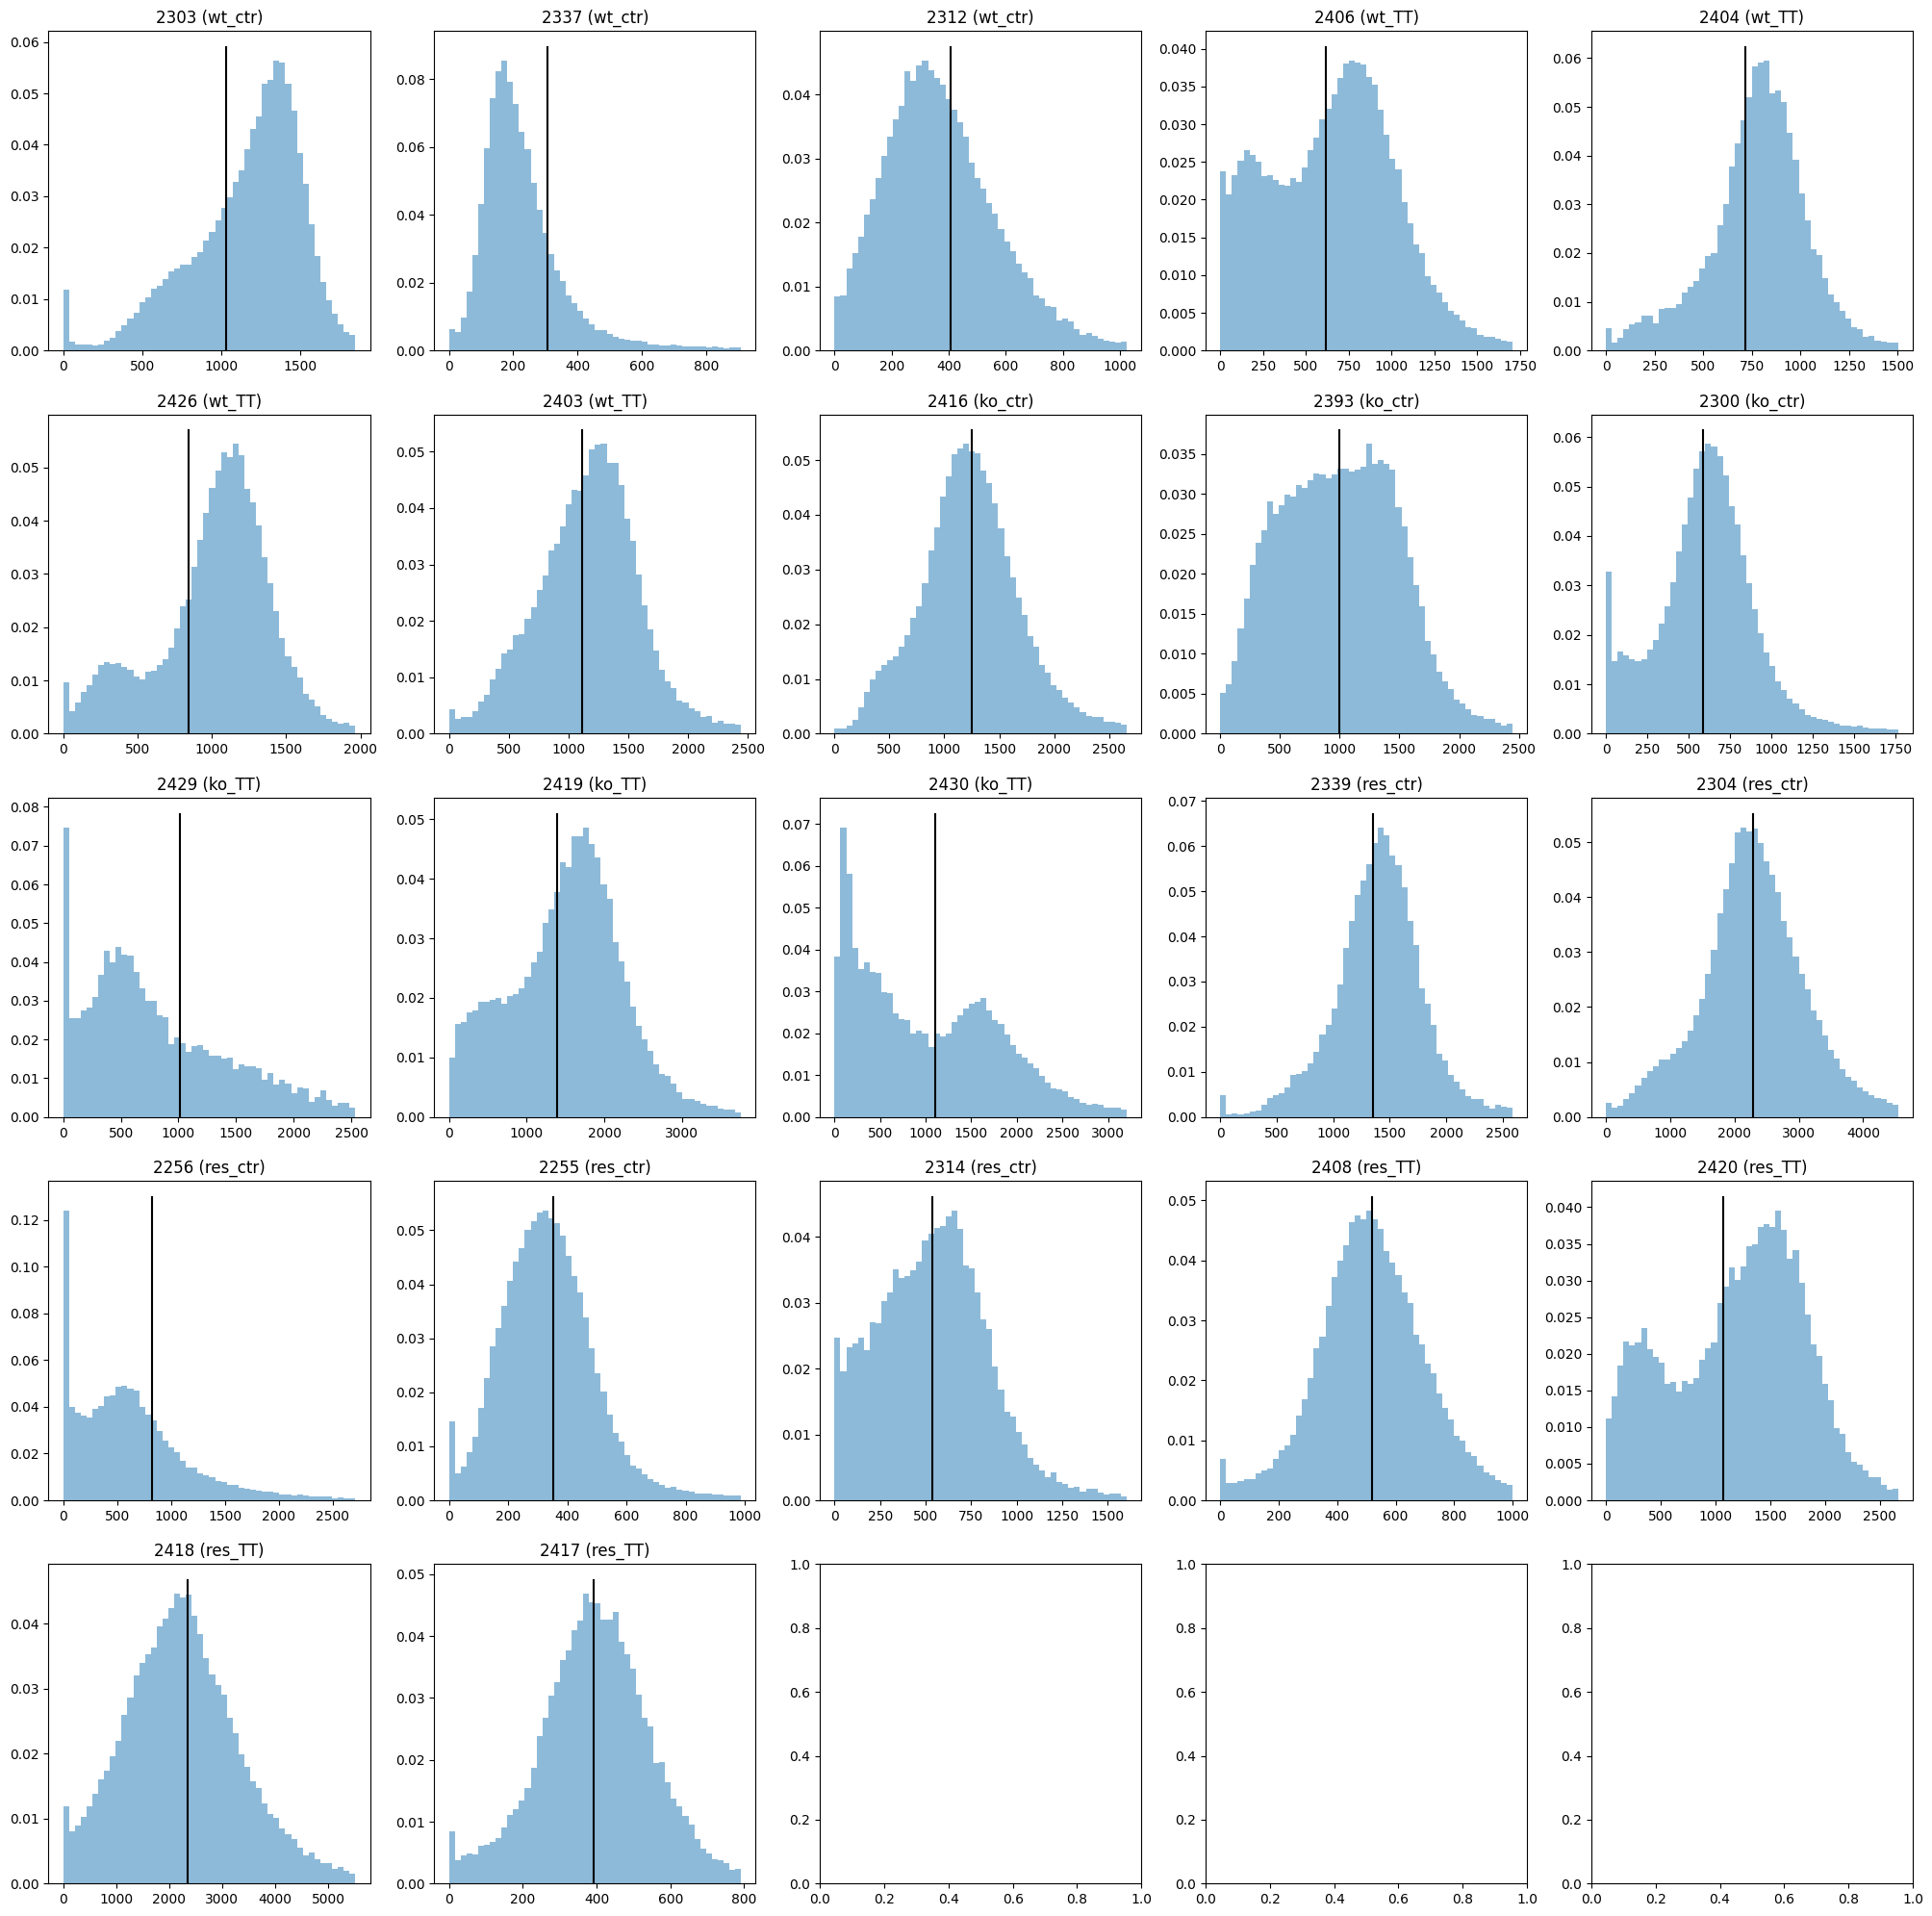

In [5]:
threshold_dict = {}

for bin_marker in ['cell_gfp_mean', 'ki67_mean', 'ccasp_mean']:
    threshold_dict[bin_marker] = {}
    fig, axis = plt.subplots(5,5, figsize=(25, 25))#, sharex=True, sharey=True)
    ax = axis.ravel()
    for i, s_id in enumerate(df_clean.slide_id.unique()):
        pltval = df_clean.loc[df_clean.slide_id == s_id][bin_marker]
        pltval = pltval[pltval < np.quantile(pltval, 0.98)] * 500
        weights = np.ones_like(pltval) / len(pltval)
        t_val, _ = cv2.threshold(np.array(pltval).astype('uint16'), 0, 1, cv2.THRESH_OTSU)
        ax[i].hist(pltval, bins=50, weights=weights, alpha=0.5)
        yy = ax[i].get_ylim()
    
        threshold_dict[bin_marker][s_id] = t_val / 500
        
        ax[i].set_title(f'{s_id} ({condition_dict[s_id]})')
        ax[i].vlines(x=t_val, ymin=0, ymax=yy[-1], color='black')

        # plt.savefig(os.path.join(figures_dir, f'histogram_{bin_marker}_'), dpi=300)
        # ax[i].vlines(x=nt_val, ymin=0, ymax=0.035, color='green')

In [6]:
for bin_marker in ['cell_gfp_mean', 'ki67_mean', 'ccasp_mean']:
    
    positive = []
    for s_id, threshold in threshold_dict[bin_marker].items():
        positive.append(df_clean.loc[df_clean.slide_id == s_id, bin_marker] > threshold)
    
    df_clean.loc[:, f'{bin_marker}_positive'] = pd.concat(positive)
    
df_gfp_positive = df_clean.loc[df_clean.cell_gfp_mean_positive].reset_index()
df_ki67_positive = df_clean.loc[df_clean.ki67_mean_positive].reset_index()
df_ccasp_positive = df_clean.loc[df_clean.ccasp_mean_positive].reset_index()

    
df_gfp_negative = df_clean.loc[~df_clean.cell_gfp_mean_positive].reset_index()

In [7]:
boxplot_dir = os.path.join(figures_dir, 'boxplots')
Path(boxplot_dir).mkdir(exist_ok=True, parents=True)

In [8]:
m_a = []
for amount in ['mean', 'max']:
    for measure in ['slug', 'ki67', 'ccasp', 'c-myc']:
        m_a.append([measure, amount]) 

# conditions = []
# for c in ['wt', 'ko', 'res']:
#     for t in ['TT', 'ctr']:
#         conditions.append(f'{c}_{t}')


# conditions = ['wt_ctr', 'wt_TT', 'ko_ctr', 'ko_TT', 'res_ctr', 'res_TT']

# print(m_a)
# print(conditions)

In [9]:
textargs=dict(
    x=0.05, 
    y=0.95,
    horizontalalignment='left',
    verticalalignment='top', 
    fontsize=10,
    c='black',
    weight='normal'
)


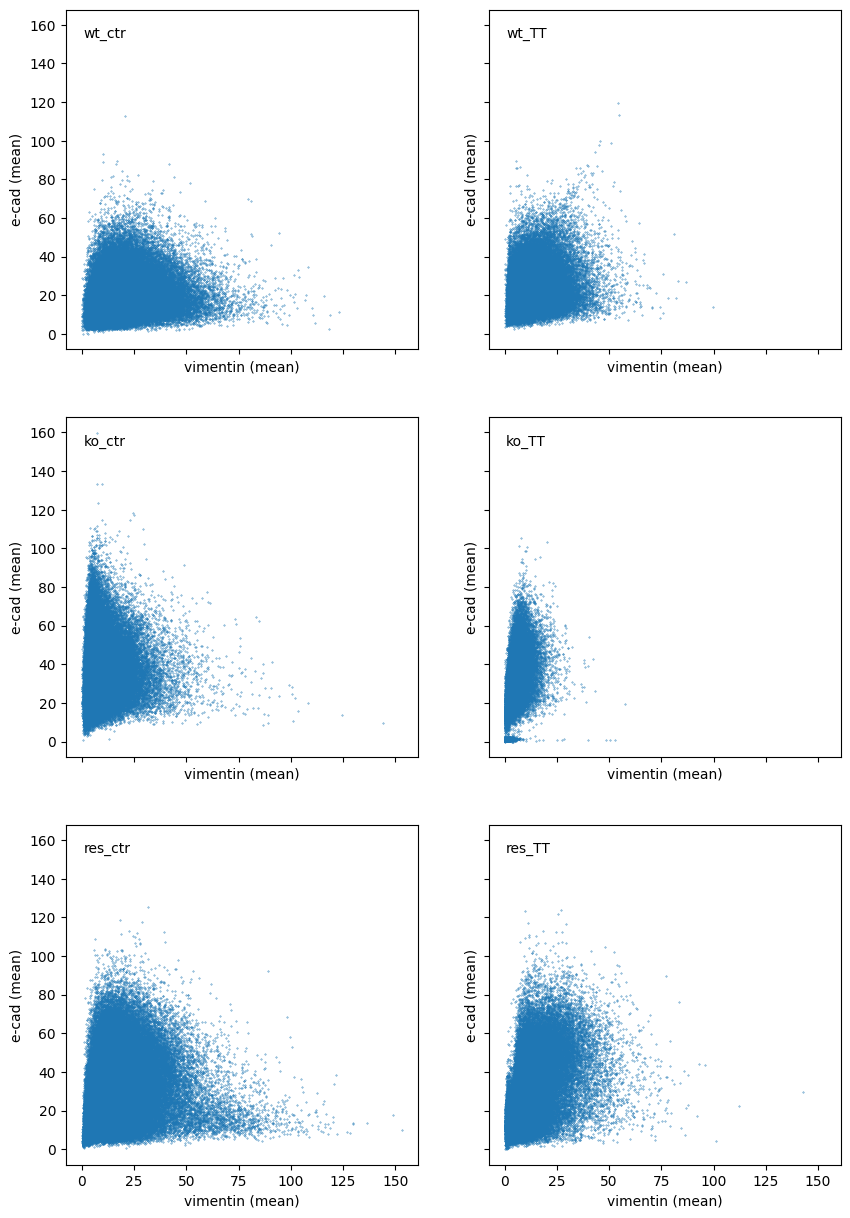

In [10]:
size_unit = 5
fig, axes = plt.subplots(3, 2, figsize=(2 * size_unit, 3 * size_unit), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    dd = df_gfp_positive.loc[df_gfp_positive.condition == conditions[i]]
    ax.scatter(dd.cell_vim_mean, dd.cell_ecad_mean, s=0.1, alpha=1, rasterized=True)
    ax.text(
        s= f'{conditions[i]}',
        transform=ax.transAxes,
        **textargs
        )
    ax.set_xlabel('vimentin (mean)')
    ax.set_ylabel('e-cad (mean)')
#fig.tight_layout(rect=[0.025, 0.02, 1, 1])
# fig.supxlabel('vimentin (mean)')
# fig.supylabel('ecad (mean)')
plt.savefig(os.path.join(figures_dir, 'vimentin_ecad_correlation_CELL.svg'), dpi=300)

In [11]:
# yy = [df_clean.loc[df_clean.condition==c, measure] for c in conditions]
# x_ = [list(range(len(d))) for d in yy]
# y_ = [sorted(d) for d in yy]
# dy = [np.diff(y) for y in y_]
# ddy = [np.diff(y) for y in dy]

In [12]:
cond_colors = ('indianred', 'gold', 'yellowgreen', 'turquoise', 'mediumblue', 'orchid')
dict_cond_colors = dict(zip(conditions, cond_colors))

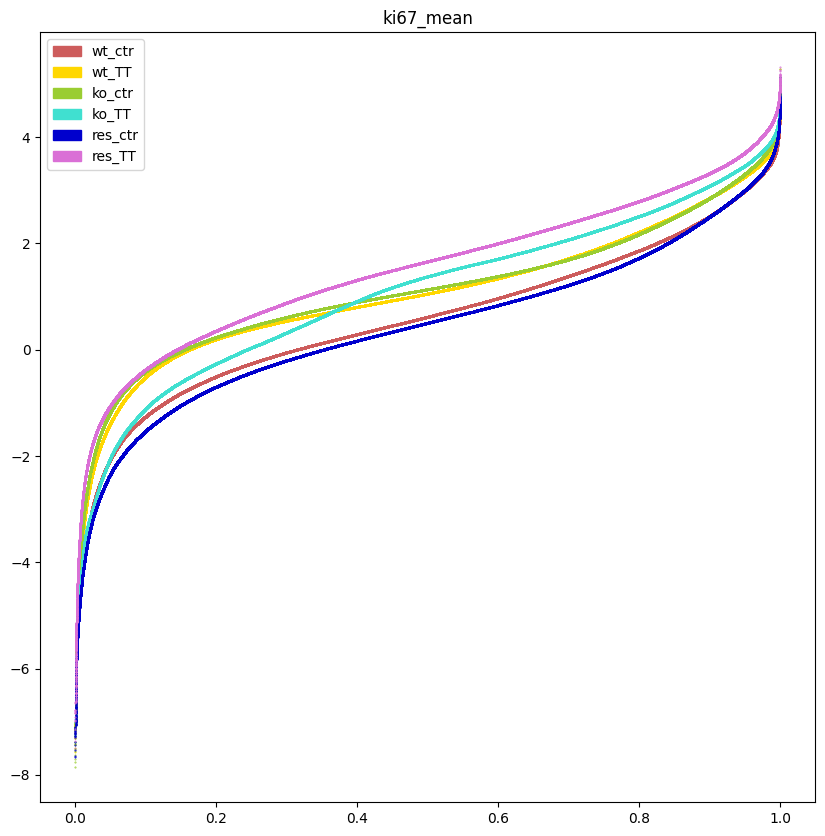

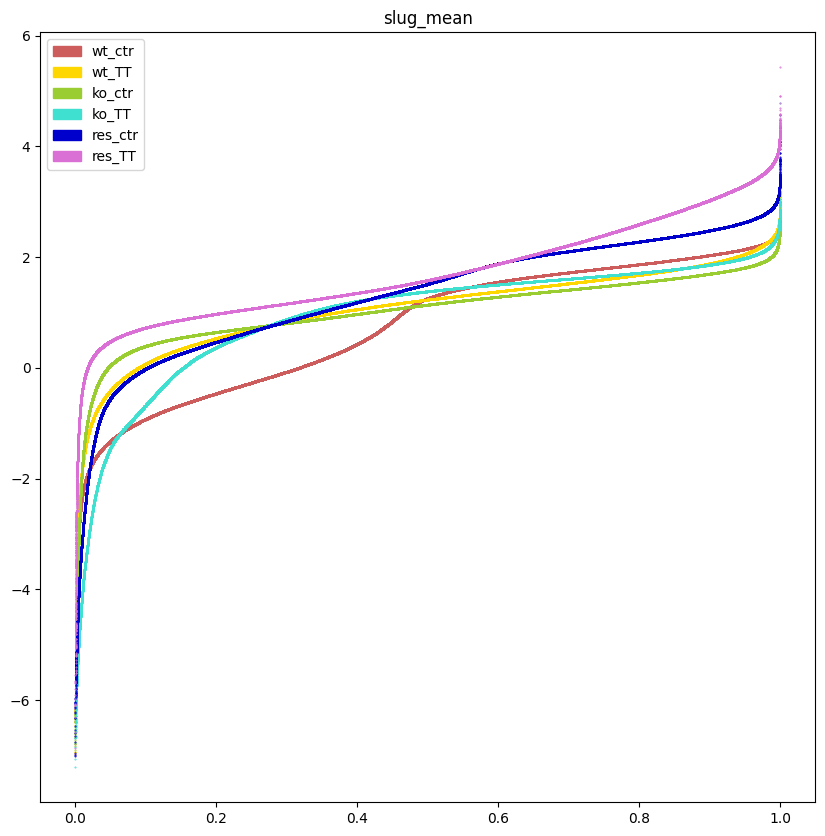

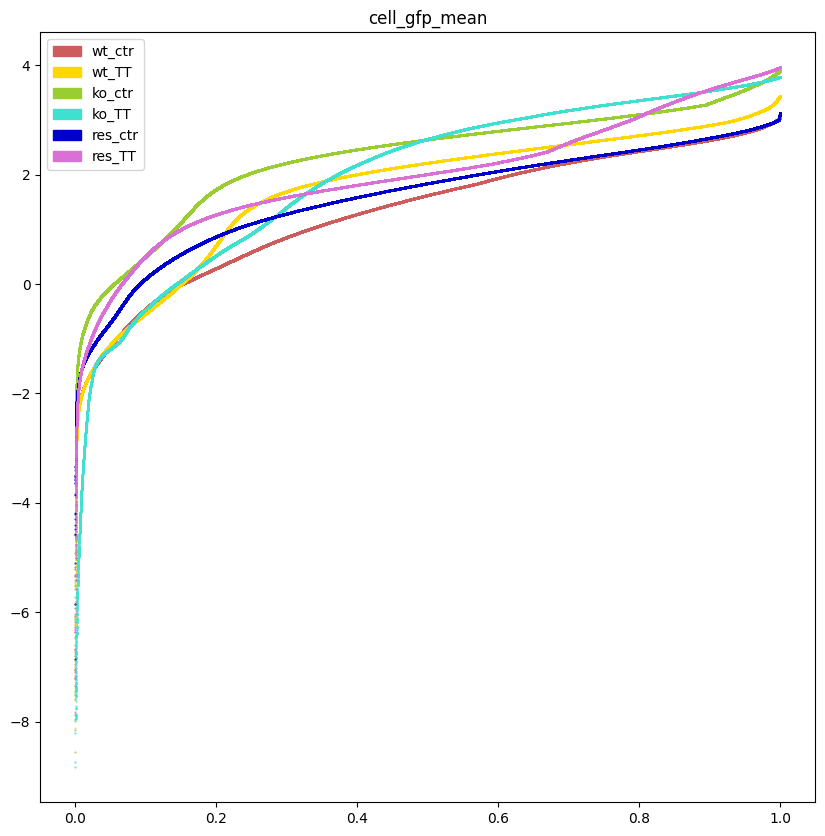

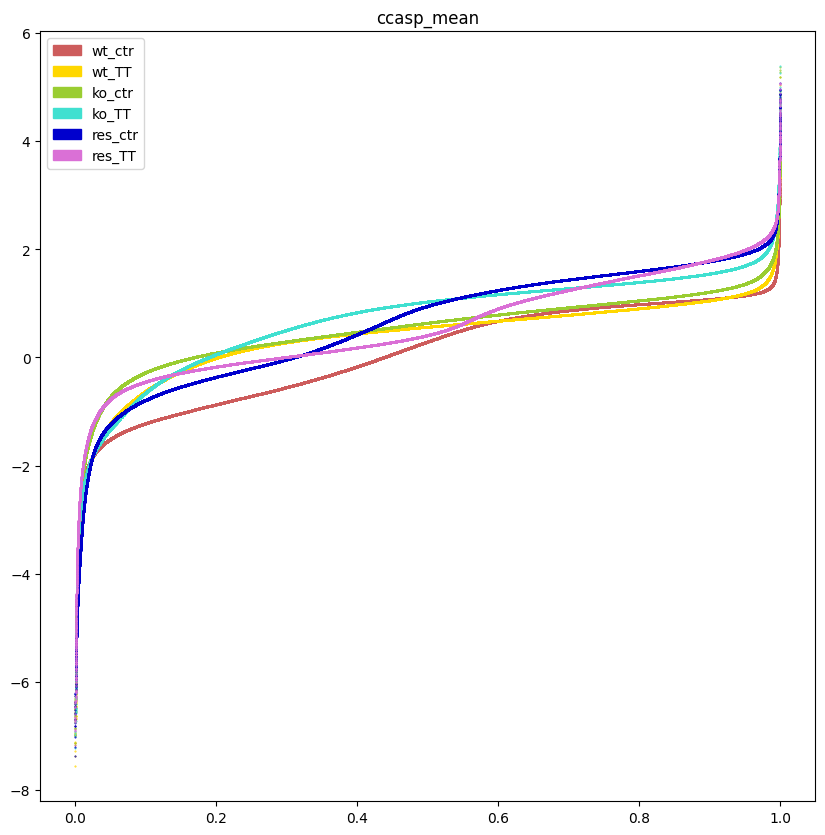

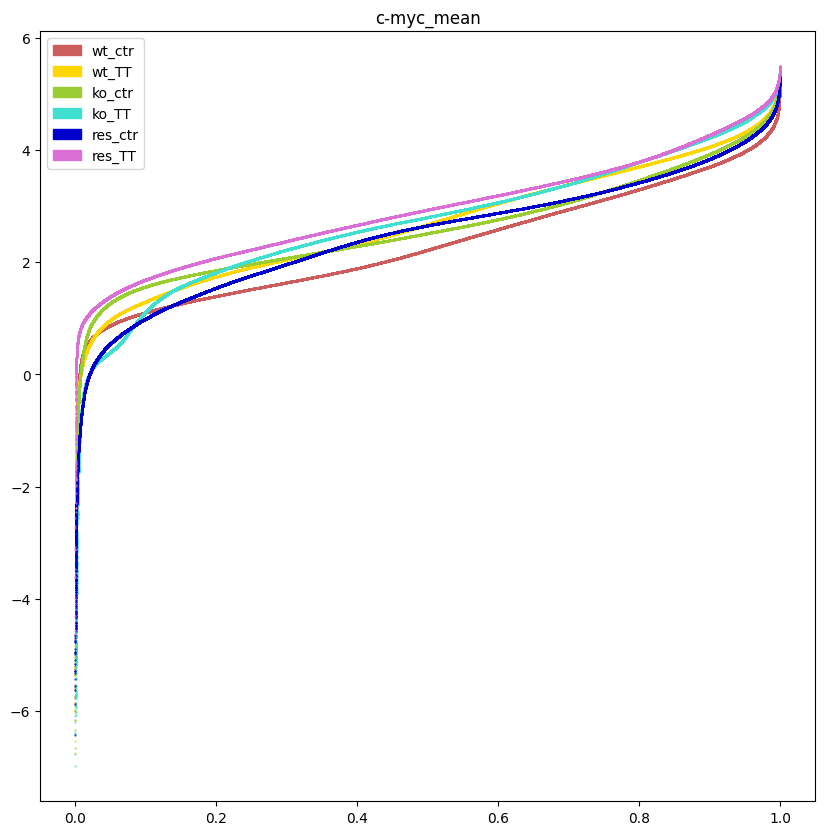

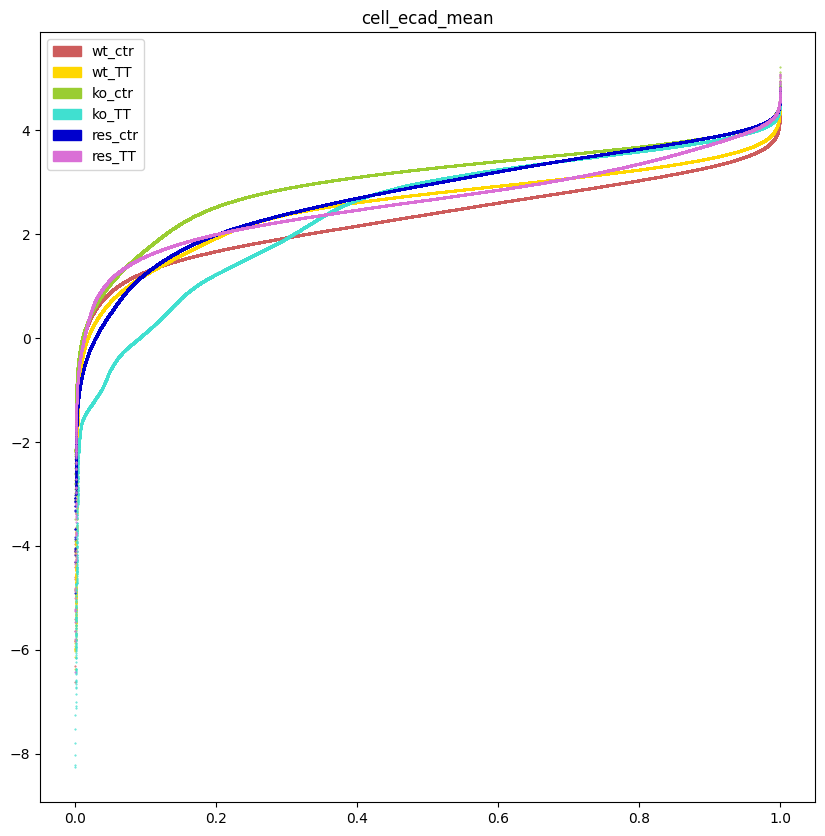

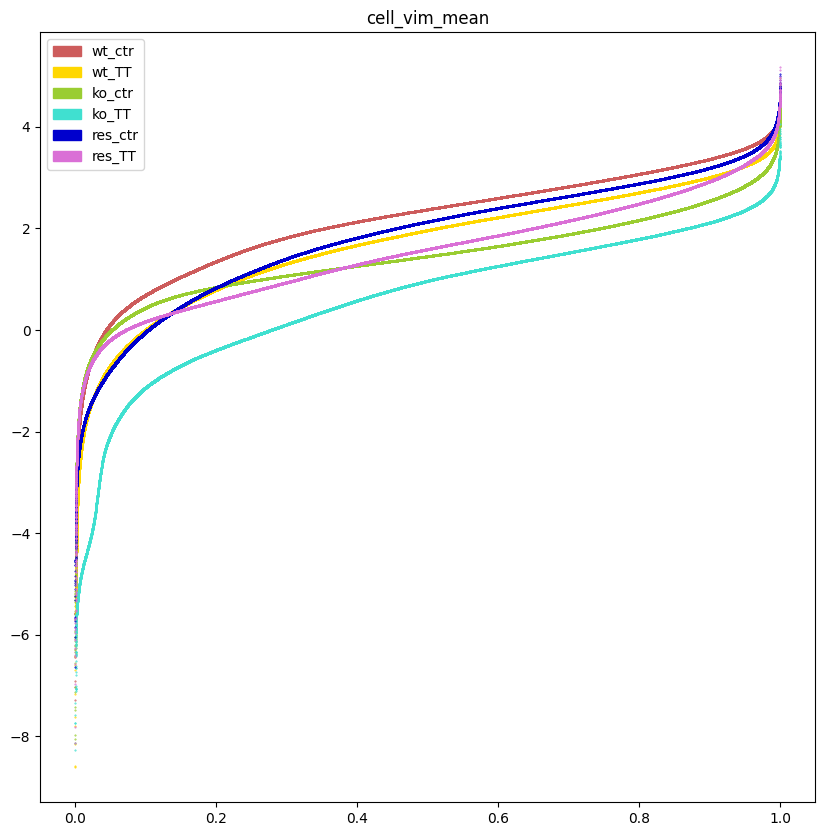

In [13]:
# def coolplot(data):

for measure in to_analyze:
    
    def rel_length(l, n_remove=0):
        if n_remove:
            l = l[:-n_remove]
        return np.divide(l, len(l))
    
    fig, axes = plt.subplots(1,1, figsize=(10,10), sharex=True)
    patches = []
    for c in conditions:
        yy = df_clean.loc[df_clean.condition==c]

        patches.append(mpatches.Patch(color = dict_cond_colors[c], label=c))
        
        data = yy[measure]
        data = data[data > 0]
        x_ = list(range(len(data)))
        y_ = sorted(data)
        dy = np.diff(y_)
        ddy = np.diff(dy)

    # yy = [df_clean.loc[df_clean.condition==c, measure] for c in conditions]
    # x_ = [list(range(len(d))) for d in yy]
    # y_ = [sorted(d) for d in yy]
    # dy = [np.diff(y) for y in y_]
    # ddy = [np.diff(y) for y in dy]
        
        axes.scatter(
            rel_length(x_), 
            np.log(y_),
            s=0.2,
            c = dict_cond_colors[c]
        )
        axes.set_title(measure)
        # axes.set_xlim(0.7, 1)
        
        # mdy = pd.Series(np.log(dy)).rolling(window=150).mean()#rolling(window=15).mean()
        # axes[1].scatter(
        #     rel_length(list(range(len(mdy[mdy != None])))),
        #     mdy[mdy != None],
        #     #np.log(dy),
        #     s=0.1,
        #     alpha = 0.1,
        #     c = dict_cond_colors[c]
        # )
        
        # axes[2].scatter(
        #     rel_length(x_, 2),
        #     abs(ddy),
        #     s=0.2,
        #     c = dict_cond_colors[c]
        # )

    axes.legend(handles=patches)


In [14]:
import statsmodels.api as sm

In [15]:
df_clean.condition.map(dict_cond_colors)

435490     indianred
505107     indianred
505106     indianred
505104     indianred
505103     indianred
             ...    
1584169       orchid
1584170       orchid
1584171       orchid
1584161       orchid
1588790       orchid
Name: condition, Length: 1246651, dtype: category
Categories (6, object): ['indianred' < 'gold' < 'yellowgreen' < 'turquoise' < 'mediumblue' < 'orchid']

In [16]:
from sklearn.decomposition import PCA

In [17]:
df_std = df_clean.copy(deep=True)
df_std[to_analyze] = df_std.groupby('slide_id')[to_analyze]\
    .transform(lambda x: (x - x.mean()) / x.std())

/tmp/ipykernel_129294/1799765191.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_std[to_analyze] = df_std.groupby('slide_id')[to_analyze]\


In [18]:
Xpre = df_clean.groupby('condition', observed=True).sample(3_000)
X = Xpre.loc[:, to_analyze]
pca = PCA(n_components=2)
X2 = pca.fit(X).transform(X)

(-25.0, 75.0)

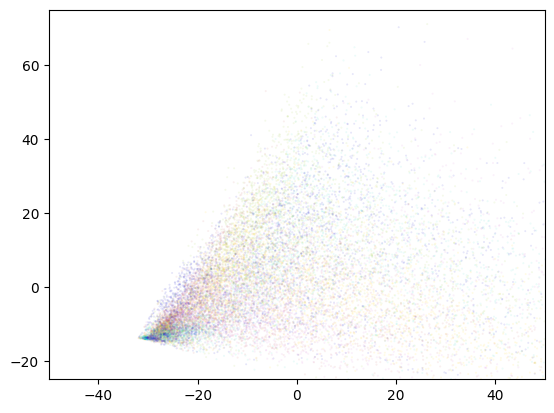

In [19]:
plt.scatter(X2[:,0], X2[:,1], s=0.2, alpha=0.1, c=Xpre.condition.map(dict_cond_colors))
plt.xlim(-50, 50)
plt.ylim(-25, 75)

In [20]:
tsne = TSNE(n_components=2, perplexity=45, verbose=True, random_state=221, n_jobs=20)


In [21]:
%%time
tsne = TSNE(n_components=2, perplexity=45, verbose=True, random_state=221, n_jobs=-1)
df_tsne_coords = tsne.fit_transform(X) 

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.013s...
[t-SNE] Computed neighbors for 18000 samples in 1.431s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sa

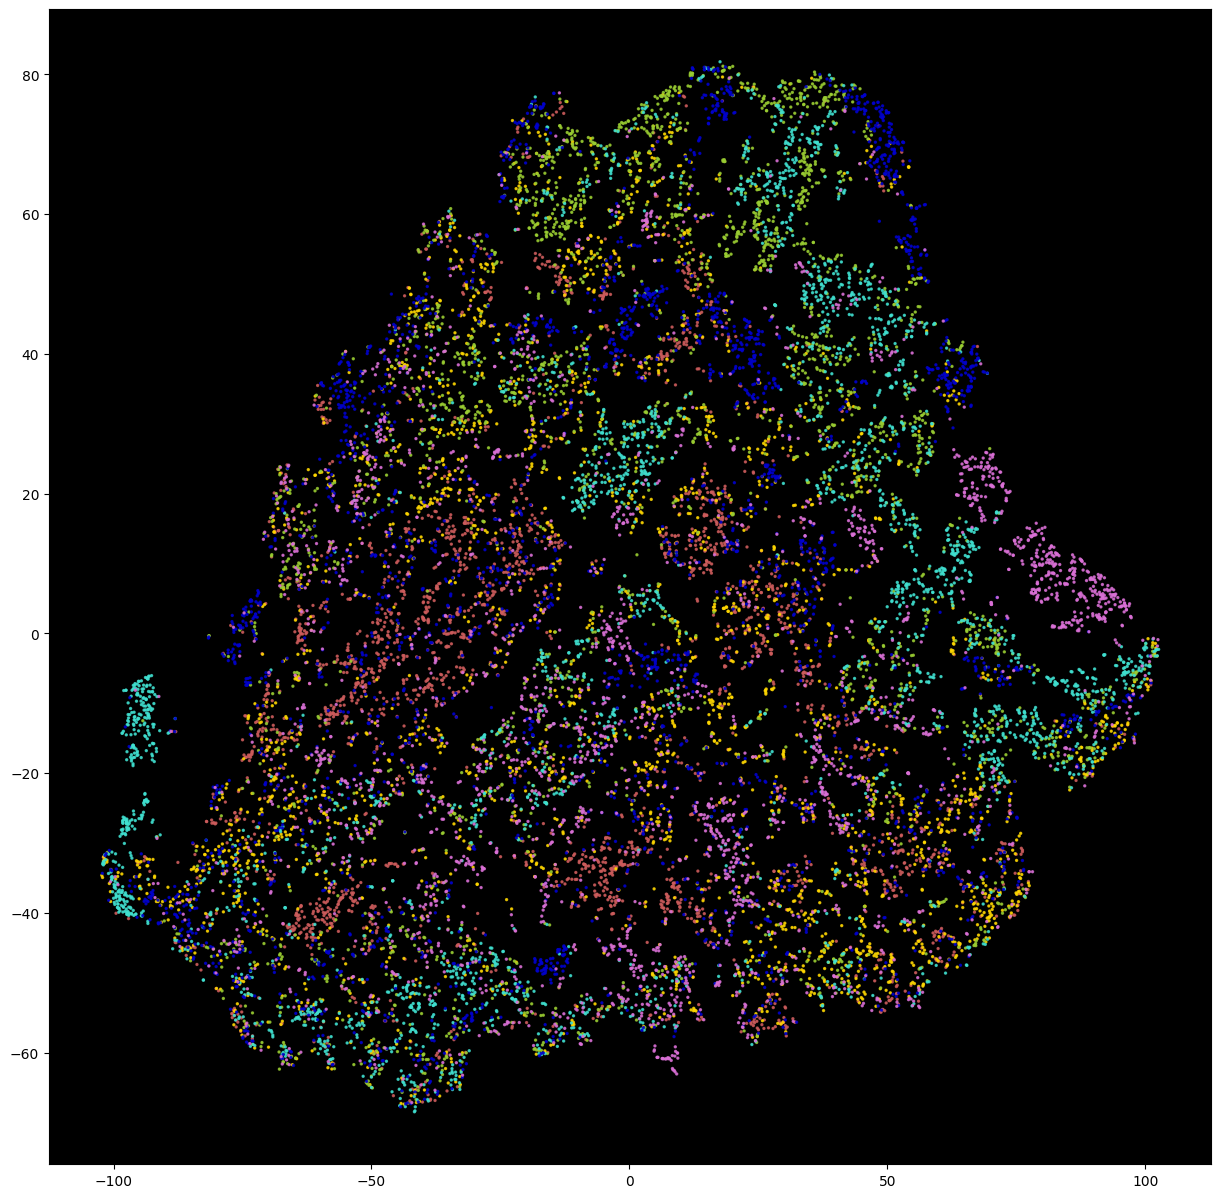

In [31]:
plt.figure(figsize=(15,15))
plt.scatter(
    df_tsne_coords[:, 0],
    df_tsne_coords[:, 1],
    c=Xpre['condition'].map(dict_cond_colors),
    s=2,
    alpha=0.8
)
ax = plt.gca()
ax.set_facecolor('k')


(array([[622., 833., 384., ...,   0.,   0.,   0.],
        [ 48., 541., 587., ...,   0.,   0.,   0.],
        [ 13.,  64., 234., ...,   0.,   2.,   2.],
        ...,
        [  0.,   0.,   0., ...,   2.,   0.,   1.],
        [  0.,   0.,   0., ...,   1.,   0.,   1.],
        [  0.,   0.,   0., ...,   1.,   0.,   1.]]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
        27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
        33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
        38.5, 39. , 39.5, 40. ]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9.

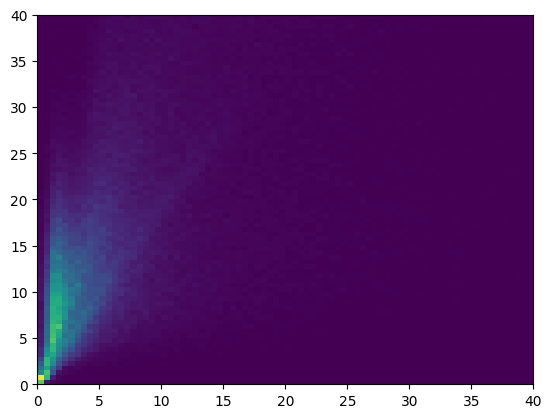

In [23]:
plt.hist2d(
        yy.cell_vim_mean, 
        yy.cell_ecad_mean, 
        bins=80,  
        range=[[0, 40], [0, 40]],
        # norm=plt_colors.LogNorm(),
    )

In [27]:
%%time
linreg = lr(n_jobs=-1)

linreg.fit(dd.cell_vim_mean.values.reshape(-1,1), dd.cell_ecad_mean.values.reshape(-1,1))

CPU times: user 4.69 ms, sys: 0 ns, total: 4.69 ms
Wall time: 4.44 ms


LinearRegression(n_jobs=-1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


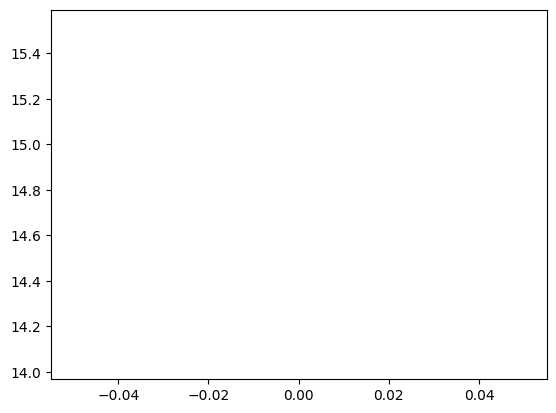

In [28]:
%time
m, b = np.polyfit(dd.cell_vim_mean.values, dd.cell_ecad_mean.values, deg=1)
plt.axline(xy1=(0, b), slope=m, c='white')

In [29]:
np.polyfit(dd.cell_vim_mean.values, dd.cell_ecad_mean.values, deg=1)

array([ 1.01292272, 14.77960886])

In [30]:
linreg = lr(n_jobs=-1, fit_intercept=False).fit(dd.cell_vim_mean.values.reshape(-1,1), dd.cell_ecad_mean.values.reshape(-1,1))

(array([  92.,  764., 3208., 5578., 5366., 4366., 3480., 2914., 2658.,
        2355., 2388., 2299., 2322., 2262., 2245., 2157., 2115., 1974.,
        1873., 1809., 1685., 1622., 1459., 1531., 1364., 1299., 1262.,
        1203., 1156., 1108., 1063.,  973.,  960.,  908.,  899.,  850.,
         780.,  802.,  762.,  724.,  694.,  683.,  650.,  584.,  592.,
         566.,  560.,  531.,  495.,  476.,  481.,  454.,  443.,  401.,
         398.,  372.,  350.,  334.,  329.,  353.,  316.,  266.,  288.,
         286.,  234.,  250.,  238.,  218.,  231.,  199.,  193.,  198.,
         185.,  202.,  210.,  171.,  184.,  157.,  163.,  140.,  155.,
         137.,  126.,  100.,  100.,   81.,   90.,   90.,   92.,   76.,
          92.,   96.,   77.,   66.,   69.,   72.,   67.,   50.,   47.,
          61.]),
 array([1.34158927e-02, 4.13072940e-01, 8.12729987e-01, 1.21238703e+00,
        1.61204408e+00, 2.01170113e+00, 2.41135818e+00, 2.81101522e+00,
        3.21067227e+00, 3.61032932e+00, 4.00998636e+00, 4.

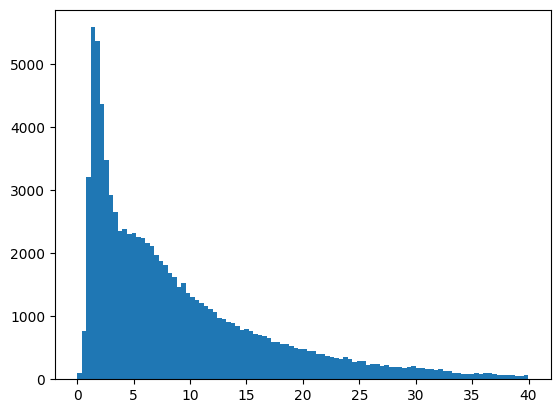

In [31]:
plt.hist(dd.cell_vim_mean[dd.cell_vim_mean < 40].values, bins=100)

In [32]:
def mask_x(x):
    return np.ma.masked_outside(x, *np.quantile(x, [0.05, 0.95]))

vm = mask_x(dd.cell_vim_mean)
em = mask_x(dd.cell_ecad_mean)

In [33]:
dd.loc[:, 'keep'] = dd.cell_vim_mean.between(*np.quantile(dd.cell_vim_mean, [0.05, 0.95])) &\
dd.cell_ecad_mean.between(*np.quantile(dd.cell_ecad_mean, [0.05, 0.95]))
dd = dd.loc[dd.keep, ['cell_vim_mean', 'cell_ecad_mean']]

/tmp/ipykernel_53219/1745528573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd.loc[:, 'keep'] = dd.cell_vim_mean.between(*np.quantile(dd.cell_vim_mean, [0.05, 0.95])) &\


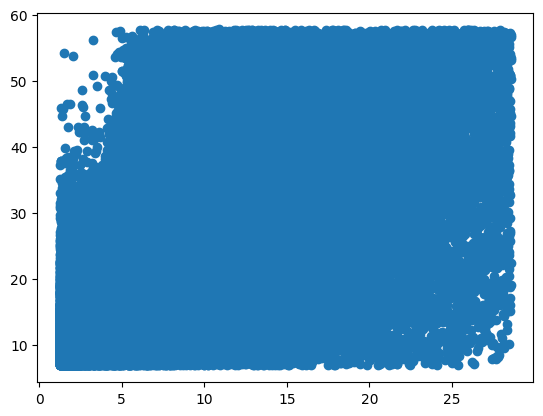

In [34]:
plt.scatter(vm, em)

/tmp/ipykernel_53219/3838151471.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd.loc[:, 'keep'] = dd.cell_vim_mean.between(*np.quantile(dd.cell_vim_mean, [0.01, 0.95])) &\
/tmp/ipykernel_53219/3838151471.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd.loc[:, 'keep'] = dd.cell_vim_mean.between(*np.quantile(dd.cell_vim_mean, [0.01, 0.95])) &\
/tmp/ipykernel_53219/3838151471.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

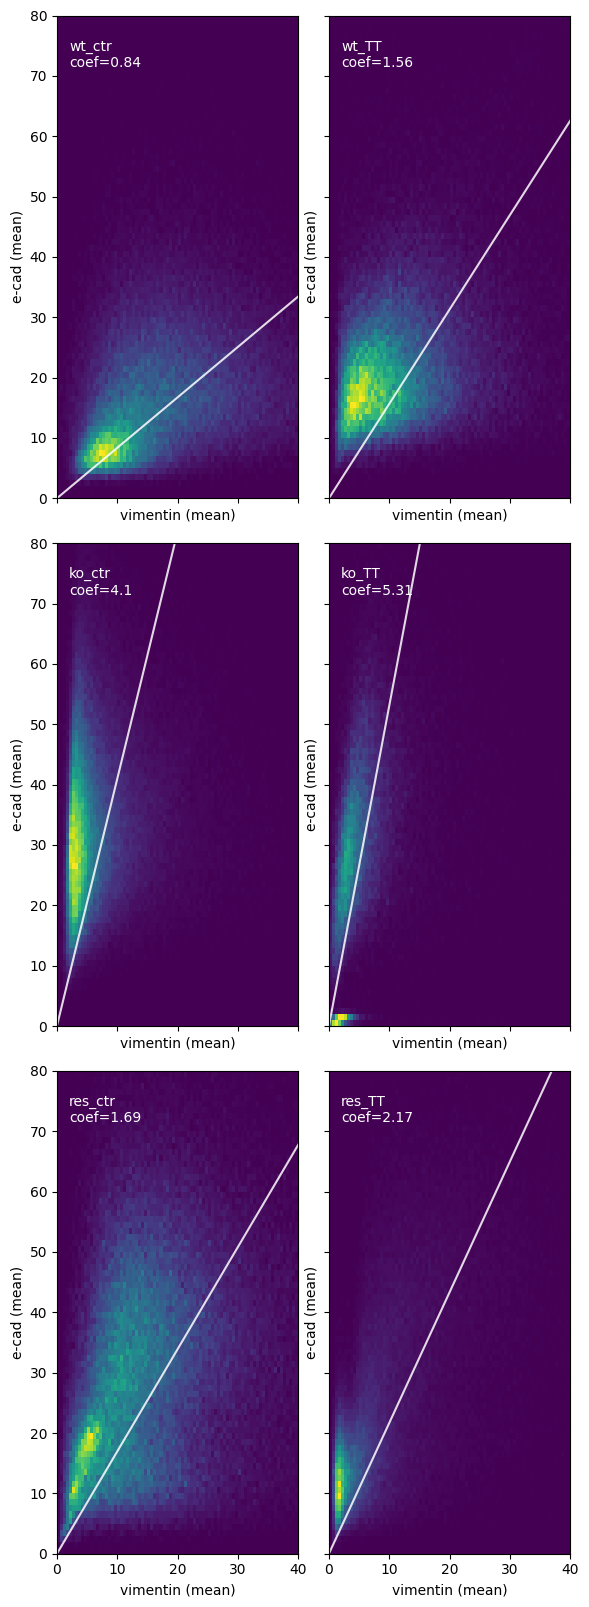

In [35]:
targs2 = textargs
targs2['c'] = 'white'

size_unit = 3

cond_slope = {}

fig, axes = plt.subplots(3, 2, figsize=(2 * size_unit, 5.5 * size_unit), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    dd = df_gfp_positive.loc[df_gfp_positive.condition == conditions[i]]
    dd.loc[:, 'keep'] = dd.cell_vim_mean.between(*np.quantile(dd.cell_vim_mean, [0.01, 0.95])) &\
        dd.cell_ecad_mean.between(*np.quantile(dd.cell_ecad_mean, [0.01, 0.95]))
    ddf = dd.loc[dd.keep, ['cell_vim_mean', 'cell_ecad_mean']]
    
    linreg = lr(n_jobs=-1, fit_intercept=False)\
        .fit(ddf.cell_vim_mean.values.reshape(-1,1), ddf.cell_ecad_mean.values.reshape(-1,1))
    m = linreg.coef_.flatten()[0]

    cond_slope[conditions[i]] = m
    
    ax.hist2d(
        dd.cell_vim_mean, 
        dd.cell_ecad_mean, 
        bins=80,  
        range=[[0, 40], [0, 80]],
        # norm=plt_colors.LogNorm(),
    )

    ax.axline(xy1=(0, 0), slope=m, c='white', alpha=0.85)
    ax.text(
        s= f'{conditions[i]}\ncoef={np.round(m, 2)}',
        transform=ax.transAxes,
        **targs2,
        )
    ax.set_xlabel('vimentin (mean)')
    ax.set_ylabel('e-cad (mean)')
    ax.axis('scaled')
    
fig.tight_layout(rect=[0.025, 0.02, 1, 1])
# fig.supxlabel('vimentin (mean)')
# fig.supylabel('ecad (mean)')

# plt.savefig(os.path.join(figures_dir, 'vimentin_ecad_correlation_CELL_heatmap.png'))

In [36]:
cond_mse = {}

for i in range(len(conditions)):
    
    c = conditions[i]
    
    dd = df_clean.loc[df_clean.condition == c, ['cell_vim_mean', 'cell_ecad_mean']]
    m = np.mean((dd.cell_vim_mean * cond_slope[c] - dd.cell_ecad_mean) ** 2)

    cond_mse[c] = m

In [37]:
cond_mse_crossed = {}

for i in range(len(conditions))[::2]:
    print(i)
    c1 = conditions[i]
    c2 = conditions[i+1]
    
    dd1 = df_clean.loc[df_clean.condition == c1, ['cell_vim_mean', 'cell_ecad_mean']]
    m1 = np.mean((dd.cell_vim_mean * cond_slope[c2] - dd.cell_ecad_mean) ** 2)

    dd2 = df_clean.loc[df_clean.condition == c2, ['cell_vim_mean', 'cell_ecad_mean']]
    m2 = np.mean((dd.cell_vim_mean * cond_slope[c1] - dd.cell_ecad_mean) ** 2)

    cond_mse_crossed[c1] = m1
    cond_mse_crossed[c2] = m2

0
2
4


In [38]:
for c in conditions:
    print( c, round(cond_mse_crossed[c] / cond_mse[c],2))

wt_ctr 2.35
wt_TT 2.1
ko_ctr 3.96
ko_TT 5.02
res_ctr 0.78
res_TT 0.82


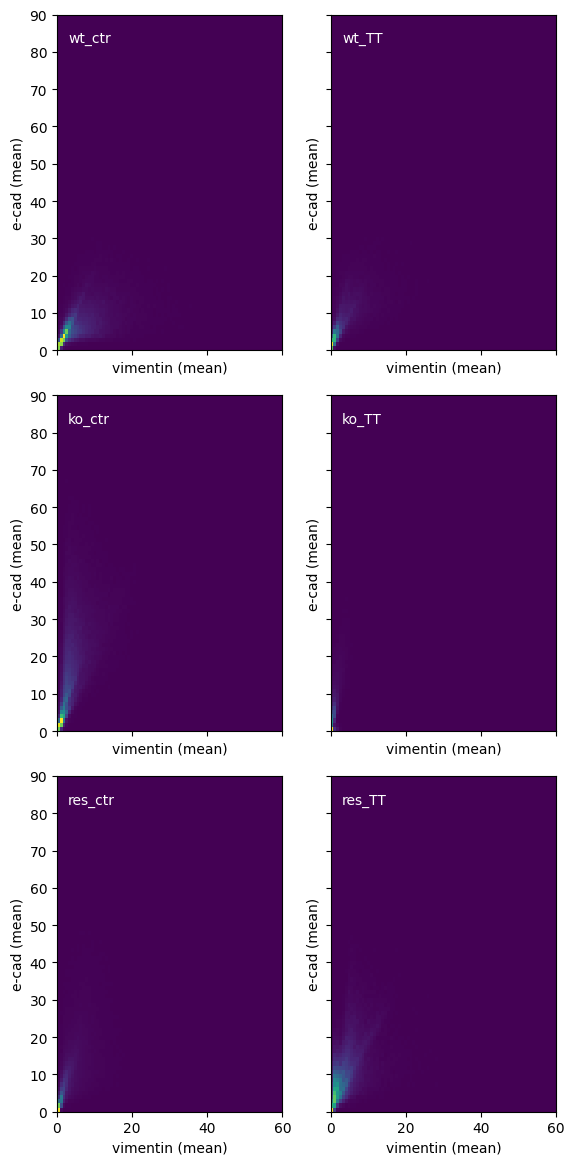

In [39]:
targs2 = textargs
targs2['c'] = 'white'

size_unit = 3

fig, axes = plt.subplots(3, 2, figsize=(2 * size_unit, 4 * size_unit), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    dd = df_gfp_negative.loc[df_gfp_negative.condition == conditions[i]]
    
    ax.hist2d(
        dd.cell_vim_mean, 
        dd.cell_ecad_mean, 
        bins=80,  
        range=[[0, 60], [0, 90]],
        # norm=plt_colors.LogNorm(),
    )

    ax.text(
        s= f'{conditions[i]}',
        transform=ax.transAxes,
        **targs2,
        )
    ax.set_xlabel('vimentin (mean)')
    ax.set_ylabel('e-cad (mean)')
fig.tight_layout(rect=[0.025, 0.02, 1, 1])
# fig.supxlabel('vimentin (mean)')
# fig.supylabel('ecad (mean)')
plt.savefig(os.path.join(figures_dir, 'vimentin_ecad_correlation_CELL_NEGATIVE_heatmap.png'))

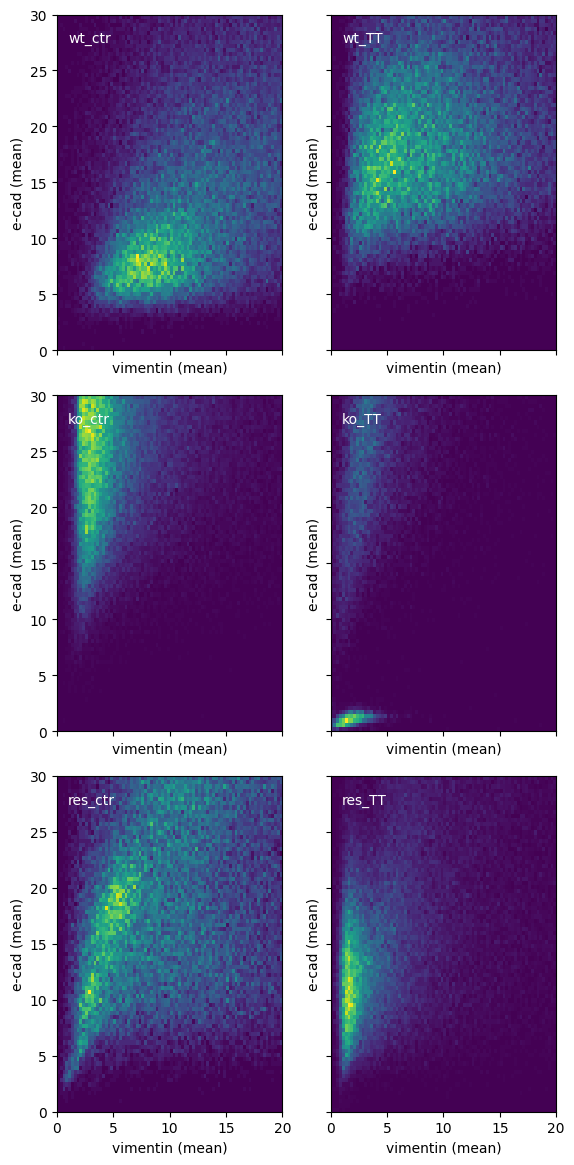

In [40]:
size_unit = 3

fig, axes = plt.subplots(3, 2, figsize=(2 * size_unit, 4 * size_unit), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    dd = df_gfp_positive.loc[df_gfp_positive.condition == conditions[i]]
    
    ax.hist2d(
        dd.cell_vim_mean, 
        dd.cell_ecad_mean, 
        bins=80,  
        range=[[0, 20], [0, 30]],
        # norm=plt_colors.LogNorm(),
    )

    ax.text(
        s= f'{conditions[i]}',
        transform=ax.transAxes,
        **targs2,
        )
    ax.set_xlabel('vimentin (mean)')
    ax.set_ylabel('e-cad (mean)')
fig.tight_layout(rect=[0.025, 0.02, 1, 1])
# fig.supxlabel('vimentin (mean)')
# fig.supylabel('ecad (mean)')
plt.savefig(os.path.join(figures_dir, 'vimentin_ecad_correlation_CELL_heatmap_origin_zoom.png'))

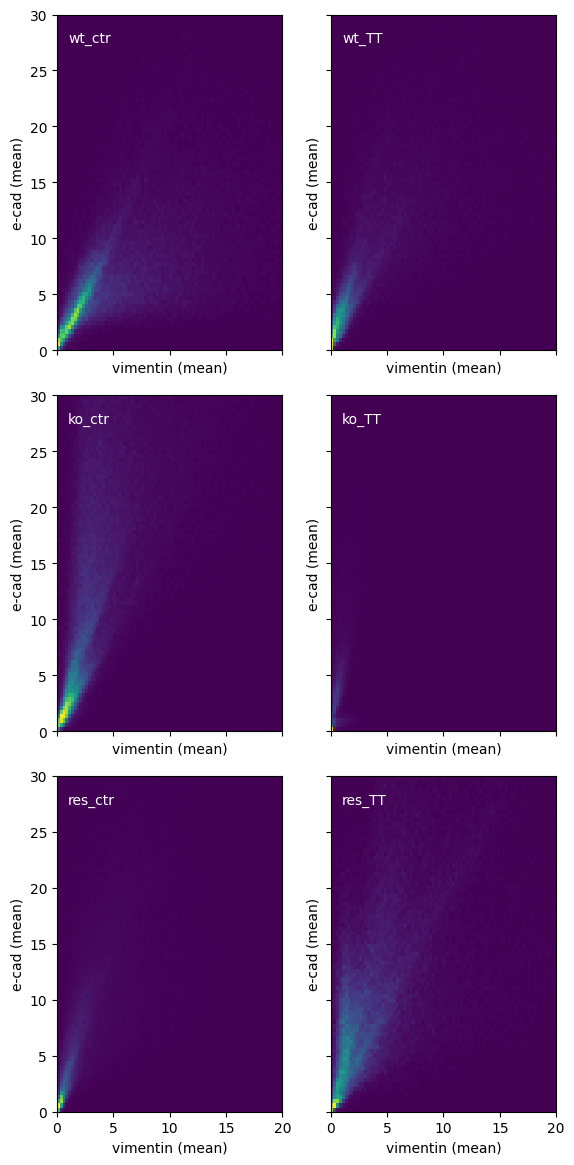

In [41]:
size_unit = 3

fig, axes = plt.subplots(3, 2, figsize=(2 * size_unit, 4 * size_unit), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    dd = df_gfp_negative.loc[df_gfp_negative.condition == conditions[i]]
    
    ax.hist2d(
        dd.cell_vim_mean, 
        dd.cell_ecad_mean, 
        bins=80,  
        range=[[0, 20], [0, 30]],
        # norm=plt_colors.LogNorm(),
    )

    ax.text(
        s= f'{conditions[i]}',
        transform=ax.transAxes,
        **targs2,
        )
    ax.set_xlabel('vimentin (mean)')
    ax.set_ylabel('e-cad (mean)')
fig.tight_layout(rect=[0.025, 0.02, 1, 1])
# fig.supxlabel('vimentin (mean)')
# fig.supylabel('ecad (mean)')
plt.savefig(os.path.join(figures_dir, 'vimentin_ecad_correlation_CELL_NEGATIVE_heatmap_origin_zoom.png'))

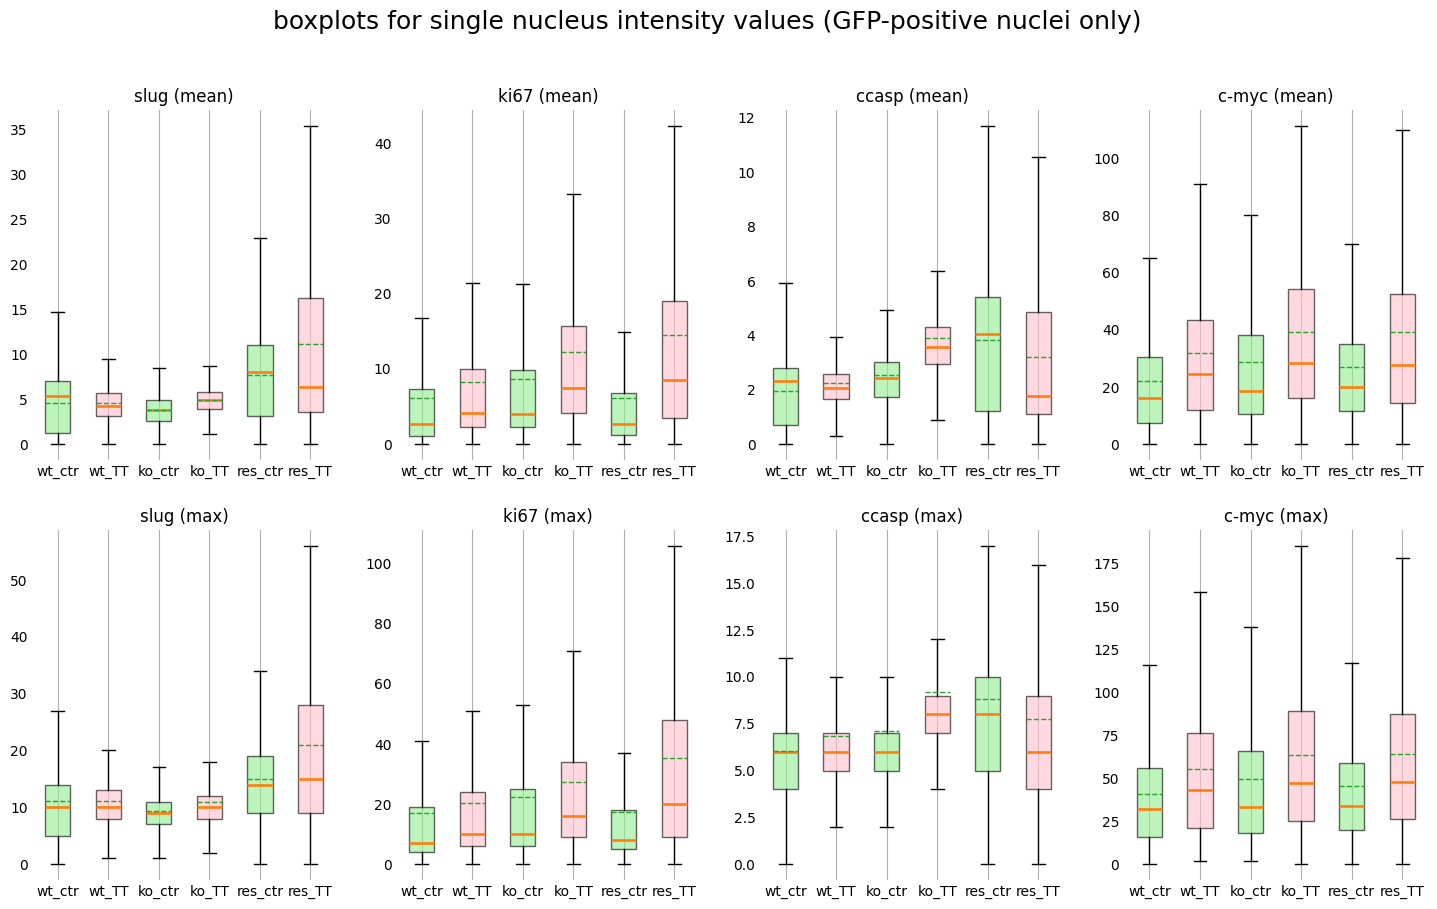

In [42]:
colors = ['lightgreen', 'pink'] * 3

fig, axes = plt.subplots(2,4, figsize=(18,10))
for i, ax in enumerate(axes.ravel()):
    m, a = m_a[i]
    ddict = {}
    
    for c in conditions:
        if c in df_gfp_positive.condition.unique():
            ddict[c] = df_gfp_positive.loc[df_gfp_positive.condition == c, f'{m}_{a}'].values
        
    boxplot1 = ax.boxplot(
        ddict.values(), 
        patch_artist=True,
        showmeans=True,
        meanline=True,
        medianprops=medianprops,
        showfliers=False
    )
    ax.set_xticklabels(ddict.keys())
    
    for box, color in zip(boxplot1['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
        box.set_edgecolor('black')

    ax.set_title(f'{m} ({a})')

    ax.set_frame_on(False)
    ax.xaxis.grid()
    ax.tick_params(length=0)

fig.suptitle('boxplots for single nucleus intensity values (GFP-positive nuclei only)', fontsize=18)

plt.savefig(os.path.join(boxplot_dir, f'positive_boxplots.png'))

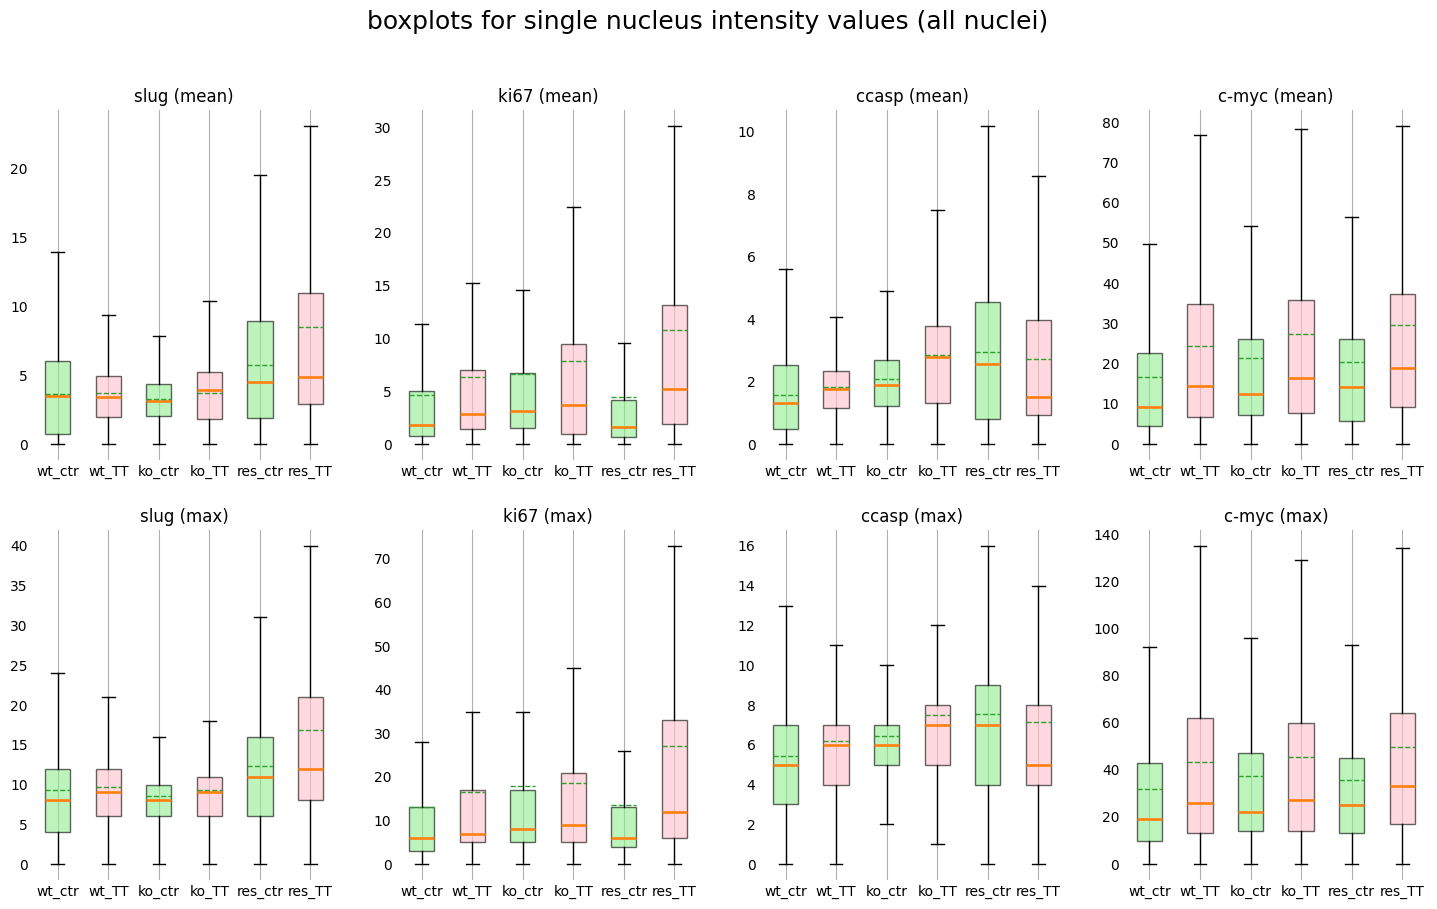

In [43]:
fig, axes = plt.subplots(2,4, figsize=(18,10))
for i, ax in enumerate(axes.ravel()):
    m, a = m_a[i]
    ddict = {}
    
    for c in conditions:
        ddict[c] = df_clean.loc[df_clean.condition == c, f'{m}_{a}'].values
    boxplot1 = ax.boxplot(
        ddict.values(), 
        patch_artist=True,
        showmeans=True,
        meanline=True,
        medianprops=medianprops,
        showfliers=False
    )
    ax.set_xticklabels(ddict.keys())
    
    for box, color in zip(boxplot1['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
        box.set_edgecolor('black')

    ax.set_title(f'{m} ({a})')
    ax.set_frame_on(False)
    ax.xaxis.grid()
    ax.tick_params(length=0)

fig.suptitle('boxplots for single nucleus intensity values (all nuclei)', fontsize=18)

plt.savefig(os.path.join(boxplot_dir, f'all_boxplots.svg'))

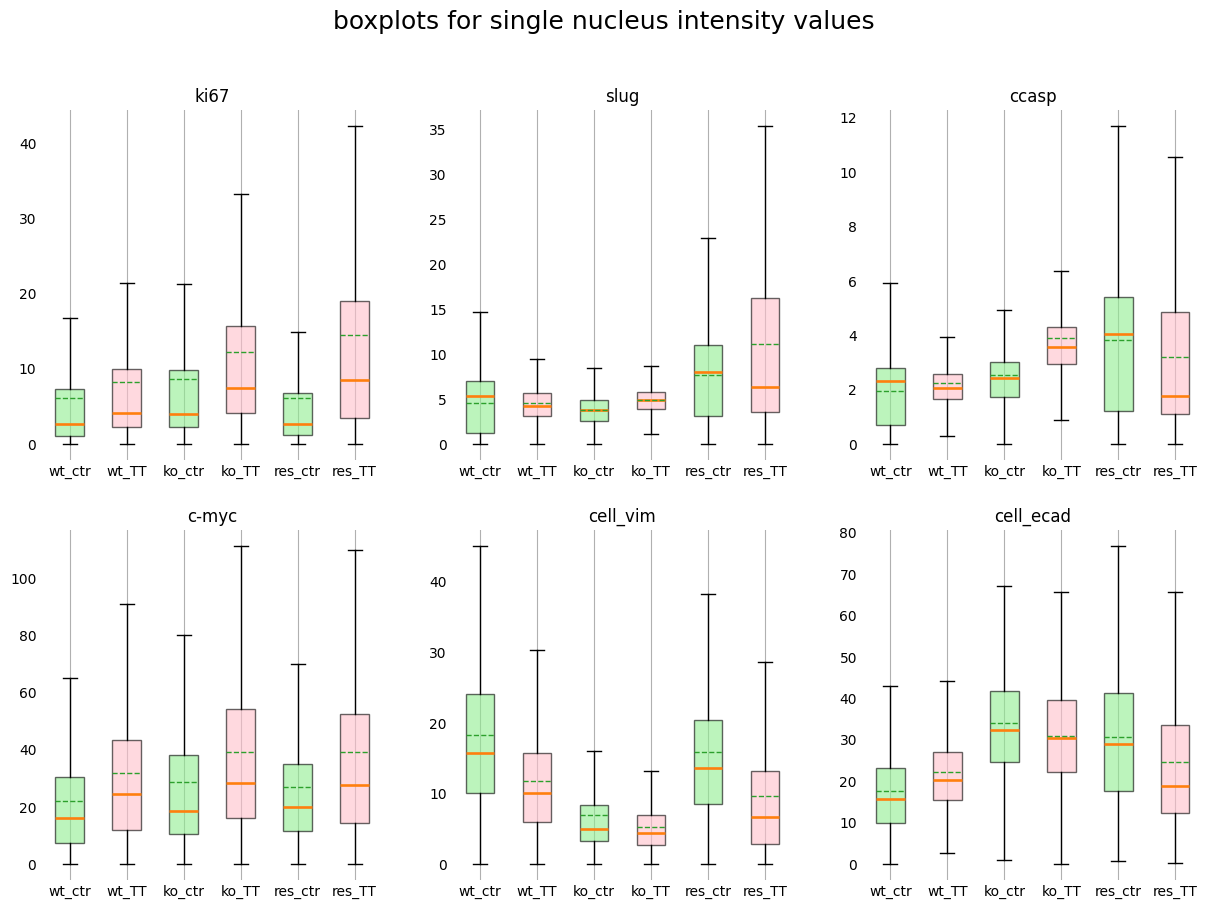

In [44]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
for i, ax in enumerate(axes.ravel()):
    ddict = {}
    
    for c in conditions:
        ddict[c] = df_gfp_positive.loc[df_gfp_positive.condition == c, f'{all_markers[i]}_mean'].values
    boxplot1 = ax.boxplot(
        ddict.values(), 
        patch_artist=True,
        showmeans=True,
        meanline=True,
        medianprops=medianprops,
        showfliers=False
    )
    ax.set_xticklabels(ddict.keys())
    
    for box, color in zip(boxplot1['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
        box.set_edgecolor('black')

    ax.set_title(f'{all_markers[i]}')
    ax.set_frame_on(False)
    ax.xaxis.grid()
    ax.tick_params(length=0)

fig.suptitle('boxplots for single nucleus intensity values', fontsize=18)

plt.savefig(os.path.join(boxplot_dir, f'all_markers_mean_boxplots.svg'))

Text(0.5, 0.98, 'boxplots for single nucleus')

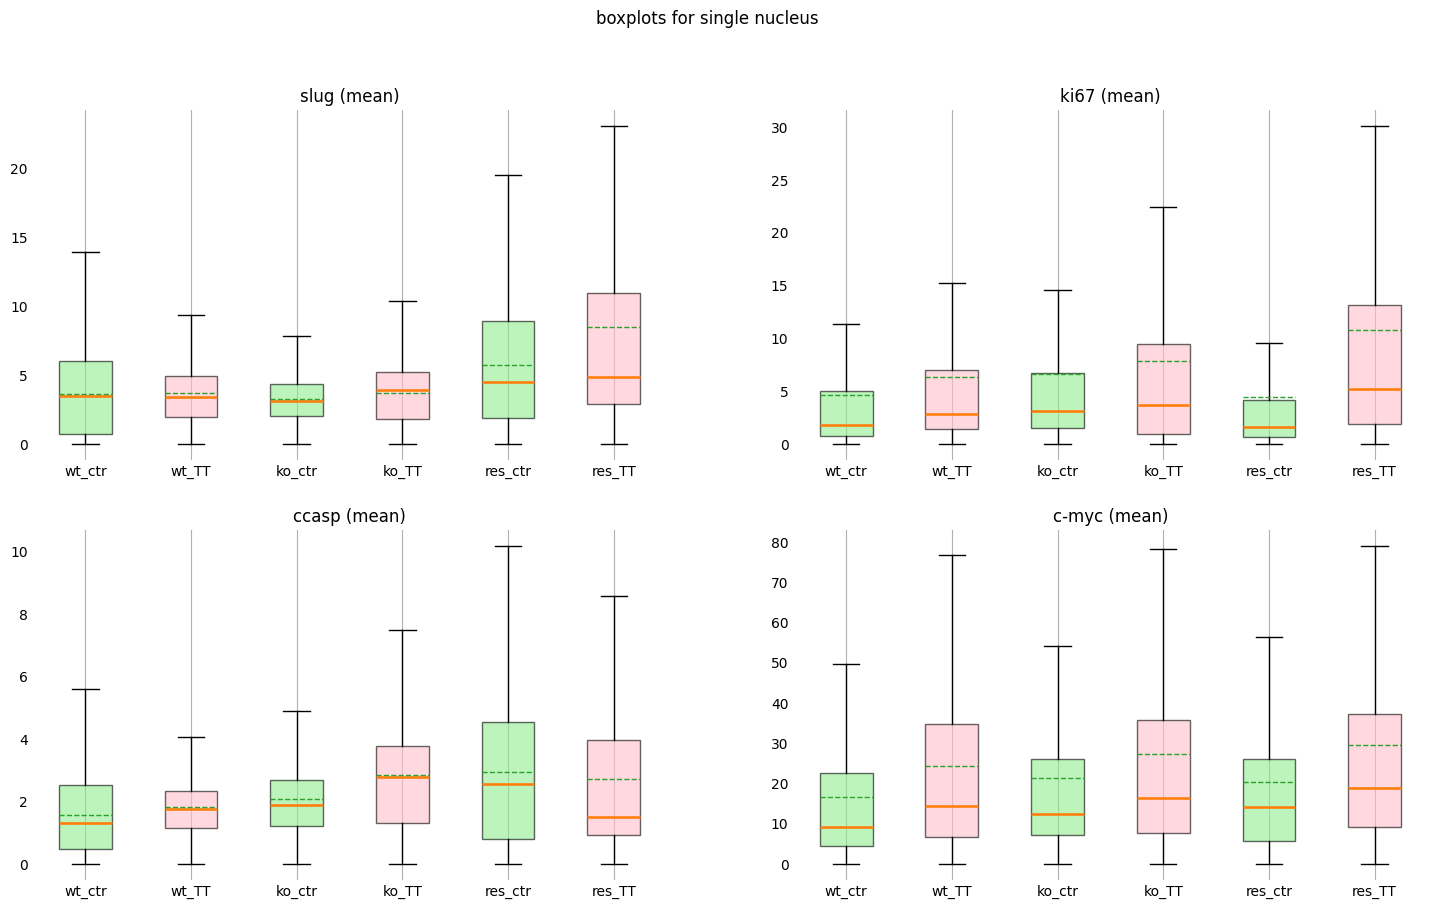

In [45]:
fig, axes = plt.subplots(2,2, figsize=(18,10))
boxplot_dict = {}
for i, ax in enumerate(axes.ravel()):
    m, a = m_a[i]
    ddict = {}
    
    for c in conditions:
        ddict[c] = df_clean.loc[df_clean.condition == c, f'{m}_mean'].values
    boxplot1 = ax.boxplot(
        ddict.values(), 
        patch_artist=True,
        showmeans=True,
        meanline=True,
        medianprops=medianprops,
        showfliers=False
    )
    boxplot_dict[m] = {key:boxplot1[key] for key in [k for k in boxplot1.keys() if k != 'fliers']}
    ax.set_xticklabels(ddict.keys())
    
    for box, color in zip(boxplot1['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
        box.set_edgecolor('black')

    ax.set_title(f'{m} ({a})')
    ax.set_frame_on(False)
    ax.xaxis.grid()
    ax.tick_params(length=0)

fig.suptitle('boxplots for single nucleus')


In [46]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def get_whiskers(boxplot_dict):
    return np.reshape([i.get_ydata()[1] for i in boxplot_dict['whiskers']], (-1,2))

def get_medians(boxplot_dict):
    return [[i.get_ydata()[1]] for i in boxplot_dict['medians']]

def get_box_quantiles(boxplot_dict):
    return [sorted(list(set(i._path._vertices[:, -1]))) for i in boxplot_dict['boxes']]

def get_data(bd):
    return [get_whiskers(bd), get_medians(bd), get_box_quantiles(bd)]

In [47]:
bp_coords = {}
for marker in boxplot_dict.keys():

    bpd = get_data(boxplot_dict[marker])
    
    fin = {}
    for j in range(6):
        fin[conditions[j]] = sorted(flatten([np.round(i[j], 2) for i in bpd]))
    
    bp_coords[marker] = fin

bp_coords

{'slug': {'wt_ctr': [0.0, 0.76, 3.48, 6.02, 13.91],
  'wt_TT': [0.0, 1.99, 3.42, 4.95, 9.38],
  'ko_ctr': [0.0, 2.06, 3.12, 4.37, 7.83],
  'ko_TT': [0.0, 1.83, 3.95, 5.26, 10.39],
  'res_ctr': [0.0, 1.9, 4.49, 8.95, 19.51],
  'res_TT': [0.0, 2.91, 4.87, 10.98, 23.09]},
 'ki67': {'wt_ctr': [0.0, 0.75, 1.84, 4.99, 11.34],
  'wt_TT': [0.0, 1.47, 2.86, 6.99, 15.28],
  'ko_ctr': [0.0, 1.54, 3.11, 6.75, 14.56],
  'ko_TT': [0.0, 0.91, 3.75, 9.52, 22.43],
  'res_ctr': [0.0, 0.64, 1.64, 4.22, 9.6],
  'res_TT': [0.0, 1.86, 5.23, 13.17, 30.13]},
 'ccasp': {'wt_ctr': [0.0, 0.49, 1.33, 2.54, 5.61],
  'wt_TT': [0.0, 1.17, 1.76, 2.33, 4.07],
  'ko_ctr': [0.0, 1.22, 1.89, 2.69, 4.89],
  'ko_TT': [0.0, 1.32, 2.8, 3.8, 7.5],
  'res_ctr': [0.0, 0.8, 2.55, 4.56, 10.19],
  'res_TT': [0.0, 0.92, 1.51, 3.99, 8.59]},
 'c-myc': {'wt_ctr': [0.0, 4.57, 9.2, 22.61, 49.65],
  'wt_TT': [0.0, 6.75, 14.52, 34.77, 76.79],
  'ko_ctr': [0.0, 7.18, 12.38, 26.02, 54.29],
  'ko_TT': [0.0, 7.61, 16.47, 35.83, 78.17],
  'res

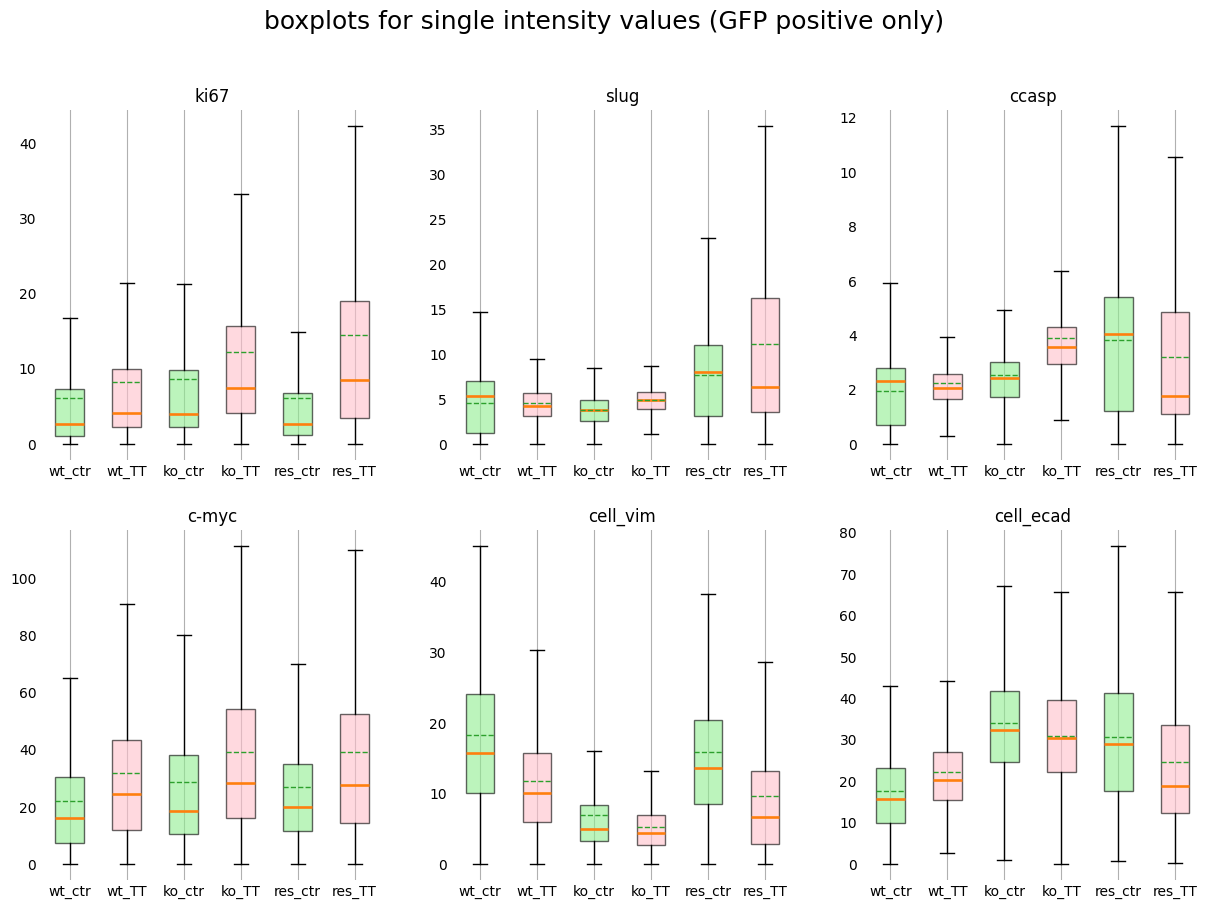

In [48]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
for i, ax in enumerate(axes.ravel()):
    ddict = {}
    
    for c in conditions:
        ddict[c] = df_gfp_positive.loc[df_gfp_positive.condition == c, f'{all_markers[i]}_mean'].values
    boxplot1 = ax.boxplot(
        ddict.values(), 
        patch_artist=True,
        showmeans=True,
        meanline=True,
        medianprops=medianprops,
        showfliers=False
    )
    ax.set_xticklabels(ddict.keys())
    
    for box, color in zip(boxplot1['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
        box.set_edgecolor('black')

    ax.set_title(f'{all_markers[i]}')
    ax.set_frame_on(False)
    ax.xaxis.grid()
    ax.tick_params(length=0)

fig.suptitle('boxplots for single intensity values (GFP positive only)', fontsize=18)

plt.savefig(os.path.join(boxplot_dir, f'all_markers_gfp_pos_mean_boxplots.svg'))

### Correlation table between all variables (mean)

In [49]:
for g in slide_ids:
    corr = df_tot.loc[df_tot.slide_id == g, to_analyze].corr()
    corr.columns = [re.sub('_mean', '', c) for c in corr.columns]   
    corr.index = [re.sub('_mean', '', c) for c in corr.index]    

    corr_styler = (corr).style\
    .background_gradient(cmap='coolwarm', vmin=-1, vmax=1)\
    .format(precision=2)\
    .set_caption(f'{g} ({condition_dict[g]})')\
    ._repr_html_()

    display_html(corr_styler, raw=True)


2255 (res_ctr) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.48 
 0.27 
 0.05 
 0.51 
 0.22 
 0.29 
 
 
 slug 
 0.48 
 1.00 
 0.54 
 0.08 
 0.48 
 0.34 
 0.43 
 
 
 cell_gfp 
 0.27 
 0.54 
 1.00 
 0.10 
 0.21 
 0.62 
 0.62 
 
 
 ccasp 
 0.05 
 0.08 
 0.10 
 1.00 
 0.02 
 0.08 
 0.03 
 
 
 c-myc 
 0.51 
 0.48 
 0.21 
 0.02 
 1.00 
 0.27 
 0.34 
 
 
 cell_ecad 
 0.22 
 0.34 
 0.62 
 0.08 
 0.27 
 1.00 
 0.47 
 
 
 cell_vim 
 0.29 
 0.43 
 0.62 
 0.03 
 0.34 
 0.47 
 1.00

2256 (res_ctr) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.36 
 0.17 
 0.12 
 0.37 
 0.11 
 0.27 
 
 
 slug 
 0.36 
 1.00 
 0.37 
 0.32 
 0.63 
 0.33 
 0.44 
 
 
 cell_gfp 
 0.17 
 0.37 
 1.00 
 0.18 
 0.23 
 0.53 
 0.53 
 
 
 ccasp 
 0.12 
 0.32 
 0.18 
 1.00 
 0.16 
 0.16 
 0.12 
 
 
 c-myc 
 0.37 
 0.63 
 0.23 
 0.16 
 1.00 
 0.30 
 0.37 
 
 
 cell_ecad 
 0.11 
 0.33 
 0.53 
 0.16 
 0.30 
 1.00 
 0.38 
 
 
 cell_vim 
 0.27 
 0.44 
 0.53 
 0.12 
 0.37 
 0.38 
 1.00

2300 (ko_ctr) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.05 
 0.08 
 0.04 
 0.39 
 0.04 
 0.14 
 
 
 slug 
 0.05 
 1.00 
 0.27 
 0.32 
 0.14 
 0.16 
 0.06 
 
 
 cell_gfp 
 0.08 
 0.27 
 1.00 
 0.14 
 0.12 
 0.47 
 0.13 
 
 
 ccasp 
 0.04 
 0.32 
 0.14 
 1.00 
 0.05 
 0.10 
 0.05 
 
 
 c-myc 
 0.39 
 0.14 
 0.12 
 0.05 
 1.00 
 0.02 
 -0.00 
 
 
 cell_ecad 
 0.04 
 0.16 
 0.47 
 0.10 
 0.02 
 1.00 
 0.27 
 
 
 cell_vim 
 0.14 
 0.06 
 0.13 
 0.05 
 -0.00 
 0.27 
 1.00

2303 (wt_ctr) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.33 
 0.15 
 0.14 
 0.47 
 0.04 
 0.27 
 
 
 slug 
 0.33 
 1.00 
 0.48 
 0.46 
 0.62 
 0.32 
 0.45 
 
 
 cell_gfp 
 0.15 
 0.48 
 1.00 
 0.39 
 0.25 
 0.55 
 0.44 
 
 
 ccasp 
 0.14 
 0.46 
 0.39 
 1.00 
 0.25 
 0.29 
 0.26 
 
 
 c-myc 
 0.47 
 0.62 
 0.25 
 0.25 
 1.00 
 0.09 
 0.35 
 
 
 cell_ecad 
 0.04 
 0.32 
 0.55 
 0.29 
 0.09 
 1.00 
 0.38 
 
 
 cell_vim 
 0.27 
 0.45 
 0.44 
 0.26 
 0.35 
 0.38 
 1.00

2304 (res_ctr) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.37 
 0.24 
 0.13 
 0.46 
 0.07 
 0.24 
 
 
 slug 
 0.37 
 1.00 
 0.72 
 0.43 
 0.52 
 0.36 
 0.39 
 
 
 cell_gfp 
 0.24 
 0.72 
 1.00 
 0.37 
 0.34 
 0.55 
 0.60 
 
 
 ccasp 
 0.13 
 0.43 
 0.37 
 1.00 
 0.26 
 0.30 
 0.20 
 
 
 c-myc 
 0.46 
 0.52 
 0.34 
 0.26 
 1.00 
 0.15 
 0.24 
 
 
 cell_ecad 
 0.07 
 0.36 
 0.55 
 0.30 
 0.15 
 1.00 
 0.43 
 
 
 cell_vim 
 0.24 
 0.39 
 0.60 
 0.20 
 0.24 
 0.43 
 1.00

2312 (wt_ctr) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.38 
 0.19 
 0.07 
 0.49 
 0.11 
 0.31 
 
 
 slug 
 0.38 
 1.00 
 0.35 
 0.22 
 0.70 
 0.30 
 0.44 
 
 
 cell_gfp 
 0.19 
 0.35 
 1.00 
 0.12 
 0.24 
 0.51 
 0.44 
 
 
 ccasp 
 0.07 
 0.22 
 0.12 
 1.00 
 0.12 
 0.10 
 0.11 
 
 
 c-myc 
 0.49 
 0.70 
 0.24 
 0.12 
 1.00 
 0.22 
 0.34 
 
 
 cell_ecad 
 0.11 
 0.30 
 0.51 
 0.10 
 0.22 
 1.00 
 0.43 
 
 
 cell_vim 
 0.31 
 0.44 
 0.44 
 0.11 
 0.34 
 0.43 
 1.00

2314 (res_ctr) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.57 
 0.29 
 0.11 
 0.48 
 -0.01 
 0.36 
 
 
 slug 
 0.57 
 1.00 
 0.59 
 0.32 
 0.58 
 0.13 
 0.54 
 
 
 cell_gfp 
 0.29 
 0.59 
 1.00 
 0.27 
 0.29 
 0.30 
 0.66 
 
 
 ccasp 
 0.11 
 0.32 
 0.27 
 1.00 
 0.25 
 0.20 
 0.17 
 
 
 c-myc 
 0.48 
 0.58 
 0.29 
 0.25 
 1.00 
 0.09 
 0.40 
 
 
 cell_ecad 
 -0.01 
 0.13 
 0.30 
 0.20 
 0.09 
 1.00 
 0.16 
 
 
 cell_vim 
 0.36 
 0.54 
 0.66 
 0.17 
 0.40 
 0.16 
 1.00

2337 (wt_ctr) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.22 
 0.22 
 0.12 
 0.47 
 0.20 
 0.30 
 
 
 slug 
 0.22 
 1.00 
 0.38 
 0.44 
 0.48 
 0.21 
 0.18 
 
 
 cell_gfp 
 0.22 
 0.38 
 1.00 
 0.21 
 0.39 
 0.32 
 0.46 
 
 
 ccasp 
 0.12 
 0.44 
 0.21 
 1.00 
 0.19 
 0.17 
 0.09 
 
 
 c-myc 
 0.47 
 0.48 
 0.39 
 0.19 
 1.00 
 0.21 
 0.35 
 
 
 cell_ecad 
 0.20 
 0.21 
 0.32 
 0.17 
 0.21 
 1.00 
 0.38 
 
 
 cell_vim 
 0.30 
 0.18 
 0.46 
 0.09 
 0.35 
 0.38 
 1.00

2339 (res_ctr) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.32 
 0.15 
 0.13 
 0.46 
 0.11 
 0.22 
 
 
 slug 
 0.32 
 1.00 
 0.56 
 0.53 
 0.53 
 0.38 
 0.45 
 
 
 cell_gfp 
 0.15 
 0.56 
 1.00 
 0.33 
 0.25 
 0.48 
 0.63 
 
 
 ccasp 
 0.13 
 0.53 
 0.33 
 1.00 
 0.36 
 0.35 
 0.24 
 
 
 c-myc 
 0.46 
 0.53 
 0.25 
 0.36 
 1.00 
 0.27 
 0.27 
 
 
 cell_ecad 
 0.11 
 0.38 
 0.48 
 0.35 
 0.27 
 1.00 
 0.42 
 
 
 cell_vim 
 0.22 
 0.45 
 0.63 
 0.24 
 0.27 
 0.42 
 1.00

2393 (ko_ctr) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.28 
 0.46 
 0.22 
 0.57 
 0.35 
 0.35 
 
 
 slug 
 0.28 
 1.00 
 0.63 
 0.47 
 0.45 
 0.52 
 0.39 
 
 
 cell_gfp 
 0.46 
 0.63 
 1.00 
 0.43 
 0.60 
 0.80 
 0.53 
 
 
 ccasp 
 0.22 
 0.47 
 0.43 
 1.00 
 0.33 
 0.37 
 0.26 
 
 
 c-myc 
 0.57 
 0.45 
 0.60 
 0.33 
 1.00 
 0.48 
 0.35 
 
 
 cell_ecad 
 0.35 
 0.52 
 0.80 
 0.37 
 0.48 
 1.00 
 0.49 
 
 
 cell_vim 
 0.35 
 0.39 
 0.53 
 0.26 
 0.35 
 0.49 
 1.00

2403 (wt_TT) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.39 
 0.18 
 0.10 
 0.48 
 0.14 
 0.31 
 
 
 slug 
 0.39 
 1.00 
 0.51 
 0.26 
 0.65 
 0.44 
 0.44 
 
 
 cell_gfp 
 0.18 
 0.51 
 1.00 
 0.23 
 0.23 
 0.55 
 0.35 
 
 
 ccasp 
 0.10 
 0.26 
 0.23 
 1.00 
 0.14 
 0.21 
 0.12 
 
 
 c-myc 
 0.48 
 0.65 
 0.23 
 0.14 
 1.00 
 0.23 
 0.33 
 
 
 cell_ecad 
 0.14 
 0.44 
 0.55 
 0.21 
 0.23 
 1.00 
 0.47 
 
 
 cell_vim 
 0.31 
 0.44 
 0.35 
 0.12 
 0.33 
 0.47 
 1.00

2404 (wt_TT) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.31 
 0.04 
 0.12 
 0.40 
 -0.01 
 0.22 
 
 
 slug 
 0.31 
 1.00 
 0.39 
 0.35 
 0.71 
 0.24 
 0.34 
 
 
 cell_gfp 
 0.04 
 0.39 
 1.00 
 0.29 
 0.18 
 0.47 
 0.17 
 
 
 ccasp 
 0.12 
 0.35 
 0.29 
 1.00 
 0.22 
 0.22 
 0.14 
 
 
 c-myc 
 0.40 
 0.71 
 0.18 
 0.22 
 1.00 
 0.01 
 0.25 
 
 
 cell_ecad 
 -0.01 
 0.24 
 0.47 
 0.22 
 0.01 
 1.00 
 0.20 
 
 
 cell_vim 
 0.22 
 0.34 
 0.17 
 0.14 
 0.25 
 0.20 
 1.00

2406 (wt_TT) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.46 
 0.31 
 0.15 
 0.50 
 0.26 
 0.37 
 
 
 slug 
 0.46 
 1.00 
 0.67 
 0.34 
 0.72 
 0.58 
 0.56 
 
 
 cell_gfp 
 0.31 
 0.67 
 1.00 
 0.31 
 0.42 
 0.74 
 0.57 
 
 
 ccasp 
 0.15 
 0.34 
 0.31 
 1.00 
 0.20 
 0.31 
 0.22 
 
 
 c-myc 
 0.50 
 0.72 
 0.42 
 0.20 
 1.00 
 0.32 
 0.38 
 
 
 cell_ecad 
 0.26 
 0.58 
 0.74 
 0.31 
 0.32 
 1.00 
 0.55 
 
 
 cell_vim 
 0.37 
 0.56 
 0.57 
 0.22 
 0.38 
 0.55 
 1.00

2408 (res_TT) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.37 
 0.17 
 0.12 
 0.39 
 0.03 
 0.10 
 
 
 slug 
 0.37 
 1.00 
 0.51 
 0.22 
 0.52 
 0.12 
 0.12 
 
 
 cell_gfp 
 0.17 
 0.51 
 1.00 
 0.25 
 0.28 
 0.44 
 0.24 
 
 
 ccasp 
 0.12 
 0.22 
 0.25 
 1.00 
 0.18 
 0.14 
 0.06 
 
 
 c-myc 
 0.39 
 0.52 
 0.28 
 0.18 
 1.00 
 0.08 
 0.07 
 
 
 cell_ecad 
 0.03 
 0.12 
 0.44 
 0.14 
 0.08 
 1.00 
 0.19 
 
 
 cell_vim 
 0.10 
 0.12 
 0.24 
 0.06 
 0.07 
 0.19 
 1.00

2416 (ko_ctr) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.12 
 0.26 
 0.12 
 0.46 
 0.11 
 0.10 
 
 
 slug 
 0.12 
 1.00 
 0.43 
 0.49 
 0.30 
 0.31 
 0.33 
 
 
 cell_gfp 
 0.26 
 0.43 
 1.00 
 0.31 
 0.37 
 0.52 
 0.06 
 
 
 ccasp 
 0.12 
 0.49 
 0.31 
 1.00 
 0.25 
 0.29 
 0.21 
 
 
 c-myc 
 0.46 
 0.30 
 0.37 
 0.25 
 1.00 
 0.14 
 0.06 
 
 
 cell_ecad 
 0.11 
 0.31 
 0.52 
 0.29 
 0.14 
 1.00 
 0.26 
 
 
 cell_vim 
 0.10 
 0.33 
 0.06 
 0.21 
 0.06 
 0.26 
 1.00

2417 (res_TT) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.43 
 0.22 
 0.06 
 0.48 
 0.08 
 0.16 
 
 
 slug 
 0.43 
 1.00 
 0.55 
 0.34 
 0.57 
 0.23 
 0.18 
 
 
 cell_gfp 
 0.22 
 0.55 
 1.00 
 0.20 
 0.34 
 0.52 
 0.23 
 
 
 ccasp 
 0.06 
 0.34 
 0.20 
 1.00 
 0.11 
 0.09 
 0.03 
 
 
 c-myc 
 0.48 
 0.57 
 0.34 
 0.11 
 1.00 
 0.19 
 0.19 
 
 
 cell_ecad 
 0.08 
 0.23 
 0.52 
 0.09 
 0.19 
 1.00 
 0.17 
 
 
 cell_vim 
 0.16 
 0.18 
 0.23 
 0.03 
 0.19 
 0.17 
 1.00

2418 (res_TT) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.51 
 0.47 
 0.18 
 0.52 
 0.38 
 0.38 
 
 
 slug 
 0.51 
 1.00 
 0.77 
 0.43 
 0.71 
 0.59 
 0.34 
 
 
 cell_gfp 
 0.47 
 0.77 
 1.00 
 0.41 
 0.62 
 0.79 
 0.44 
 
 
 ccasp 
 0.18 
 0.43 
 0.41 
 1.00 
 0.35 
 0.38 
 0.18 
 
 
 c-myc 
 0.52 
 0.71 
 0.62 
 0.35 
 1.00 
 0.57 
 0.42 
 
 
 cell_ecad 
 0.38 
 0.59 
 0.79 
 0.38 
 0.57 
 1.00 
 0.49 
 
 
 cell_vim 
 0.38 
 0.34 
 0.44 
 0.18 
 0.42 
 0.49 
 1.00

2419 (ko_TT) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.24 
 0.44 
 0.14 
 0.50 
 0.25 
 0.27 
 
 
 slug 
 0.24 
 1.00 
 0.50 
 0.39 
 0.37 
 0.42 
 0.32 
 
 
 cell_gfp 
 0.44 
 0.50 
 1.00 
 0.32 
 0.39 
 0.63 
 0.48 
 
 
 ccasp 
 0.14 
 0.39 
 0.32 
 1.00 
 0.12 
 0.23 
 0.20 
 
 
 c-myc 
 0.50 
 0.37 
 0.39 
 0.12 
 1.00 
 0.18 
 0.10 
 
 
 cell_ecad 
 0.25 
 0.42 
 0.63 
 0.23 
 0.18 
 1.00 
 0.62 
 
 
 cell_vim 
 0.27 
 0.32 
 0.48 
 0.20 
 0.10 
 0.62 
 1.00

2420 (res_TT) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.46 
 0.36 
 0.21 
 0.49 
 0.24 
 0.28 
 
 
 slug 
 0.46 
 1.00 
 0.71 
 0.47 
 0.61 
 0.32 
 0.28 
 
 
 cell_gfp 
 0.36 
 0.71 
 1.00 
 0.50 
 0.50 
 0.49 
 0.38 
 
 
 ccasp 
 0.21 
 0.47 
 0.50 
 1.00 
 0.36 
 0.25 
 0.19 
 
 
 c-myc 
 0.49 
 0.61 
 0.50 
 0.36 
 1.00 
 0.28 
 0.24 
 
 
 cell_ecad 
 0.24 
 0.32 
 0.49 
 0.25 
 0.28 
 1.00 
 0.40 
 
 
 cell_vim 
 0.28 
 0.28 
 0.38 
 0.19 
 0.24 
 0.40 
 1.00

2426 (wt_TT) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.30 
 0.14 
 0.13 
 0.47 
 0.15 
 0.28 
 
 
 slug 
 0.30 
 1.00 
 0.46 
 0.38 
 0.62 
 0.31 
 0.35 
 
 
 cell_gfp 
 0.14 
 0.46 
 1.00 
 0.30 
 0.28 
 0.35 
 0.25 
 
 
 ccasp 
 0.13 
 0.38 
 0.30 
 1.00 
 0.23 
 0.20 
 0.17 
 
 
 c-myc 
 0.47 
 0.62 
 0.28 
 0.23 
 1.00 
 0.03 
 0.24 
 
 
 cell_ecad 
 0.15 
 0.31 
 0.35 
 0.20 
 0.03 
 1.00 
 0.45 
 
 
 cell_vim 
 0.28 
 0.35 
 0.25 
 0.17 
 0.24 
 0.45 
 1.00

2430 (ko_TT) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 1.00 
 0.45 
 0.47 
 0.36 
 0.58 
 0.46 
 0.46 
 
 
 slug 
 0.45 
 1.00 
 0.73 
 0.70 
 0.66 
 0.75 
 0.57 
 
 
 cell_gfp 
 0.47 
 0.73 
 1.00 
 0.58 
 0.55 
 0.82 
 0.50 
 
 
 ccasp 
 0.36 
 0.70 
 0.58 
 1.00 
 0.54 
 0.58 
 0.44 
 
 
 c-myc 
 0.58 
 0.66 
 0.55 
 0.54 
 1.00 
 0.58 
 0.48 
 
 
 cell_ecad 
 0.46 
 0.75 
 0.82 
 0.58 
 0.58 
 1.00 
 0.63 
 
 
 cell_vim 
 0.46 
 0.57 
 0.50 
 0.44 
 0.48 
 0.63 
 1.00

2429 (ko_TT) 
 
 
   
 ki67 
 slug 
 cell_gfp 
 ccasp 
 c-myc 
 cell_ecad 
 cell_vim 
 
 
 
 
 ki67 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 slug 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 cell_gfp 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 ccasp 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 c-myc 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 cell_ecad 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 cell_vim 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan

## Heatmaps for individual samples

### Marker intensity

In [ ]:
for marker in all_markers:
    fig, axes = plt.subplots(5,5, figsize=(15,15), sharex=True, sharey=True)
    ax = axes.ravel()
    norm_value = df_tot[f'{marker}_mean'].quantile(0.97)
    for i, slide in enumerate(slide_ids.categories):
        dd = df_clean.loc[df_clean.slide_id == slide, [f'{marker}_mean', 'centroid-0', 'centroid-1']]
        ax[i].scatter(
            dd['centroid-0'], 
            dd['centroid-1'], 
            s=0.6, 
            c=np.clip(dd[f'{marker}_mean']/norm_value, 0, 1),
            rasterized=True
        )
        ax[i].set_title(f'{slide} ({condition_dict[slide]})')
    for a in ax:
        a.axis('off')
        
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, f'spatial_expression_{marker}.svg'), dpi=300)
    plt.close()

### Heatmap for positive GFP cells

In [ ]:
cdict = {True: 'gold', False: 'indigo'}

fig, axes = plt.subplots(5,5, figsize=(15,15), sharex=True, sharey=True)
ax = axes.ravel()
for i, slide in enumerate(slide_ids.categories):
    dd = df_clean.loc[df_clean.slide_id == slide, ['cell_gfp_mean_positive', 'centroid-0', 'centroid-1']]
    n_pos = dd.cell_gfp_mean_positive.sum()
    n_neg = len(dd) - n_pos
    
    ax[i].scatter(
        dd['centroid-0'], 
        dd['centroid-1'], 
        s=0.6, 
        c=dd['cell_gfp_mean_positive'].map(cdict),
        rasterized=True
    )
    ax[i].set_title(f'{slide} ({condition_dict[slide]} - {round(100*n_pos/(n_pos+n_neg),1)}%)')
for a in ax:
    a.axis('off')
    
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, f'spatial_POSITIVE.svg'), dpi=300)

## barplots for % of positive cells for...

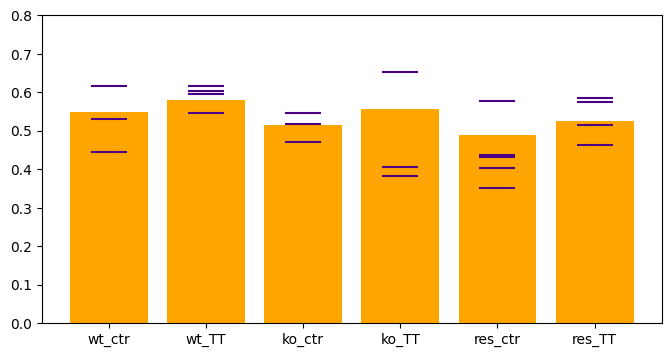

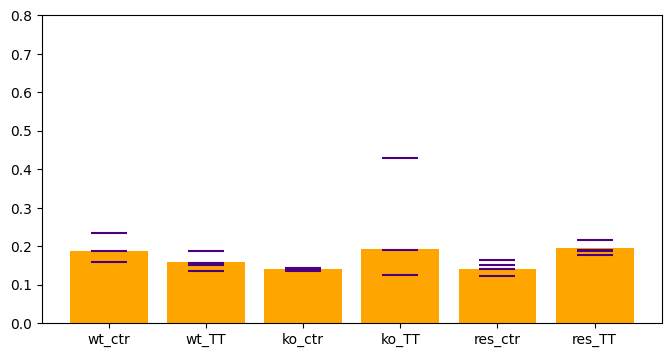

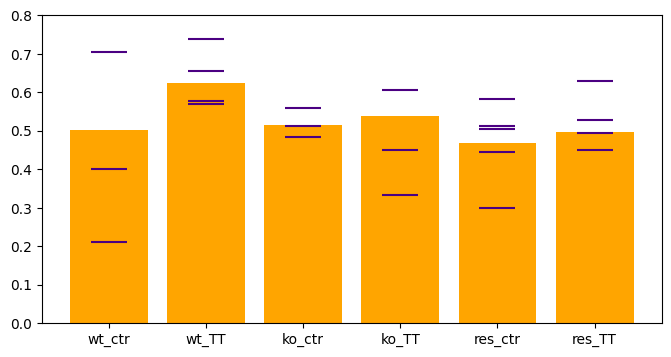

In [50]:
for marker in ['cell_gfp_mean', 'ki67_mean', 'ccasp_mean']:

    slide_dict = {d:[] for d in conditions}#sorted(df_clean.condition.unique())}
    slide_result = []
    for s in sorted(df_clean.slide_id.unique()):
        
        dd = df_clean.loc[df_clean.slide_id == s]
        cc = dd.condition.unique()[0]
        slide_dict[cc].append(float(dd[f'{marker}_positive'].sum()/len(dd)))
        slide_result.append([s, float(dd[f'{marker}_positive'].sum()/len(dd)), cc])
    
    # plt.figure(figsize=(16,4))
    # plt.bar([r[0] for r in slide_result], [r[1] for r in slide_result])
    # plt.ylim(0, .8)
    # plt.savefig(os.path.join(figures_dir, f'percentage_{marker}+_slide.svg'), dpi=300)
    
    result = {}
    for c in conditions:
        
        dd = df_clean.loc[df_clean.condition == c]
        result[c] = float(dd[f'{marker}_positive'].sum()/len(dd))
    
    plt.figure(figsize=(8,4))
    plt.bar(conditions, [result[c] for c in conditions], color='orange')
    plt.scatter([r[2] for r in slide_result], [r[1] for r in slide_result], marker='_', s=700, c='indigo')
    plt.ylim(0, .8)
    plt.savefig(os.path.join(figures_dir, f'percentage_{marker}+_category.svg'), dpi=300)


    plt.savefig(os.path.join(figures_dir, f'percentage_{marker}+_category_simple.svg'), dpi=300)


/tmp/ipykernel_53219/288442152.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_mean = df_clean.groupby(['slide_id', 'condition']).mean().groupby('condition').mean()[['cell_gfp_mean_positive',  'ki67_mean_positive', 	'ccasp_mean_positive']]
/tmp/ipykernel_53219/288442152.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_mean = df_clean.groupby(['slide_id', 'condition']).mean().groupby('condition').mean()[['cell_gfp_mean_positive',  'ki67_mean_positive', 	'ccasp_mean_positive']]


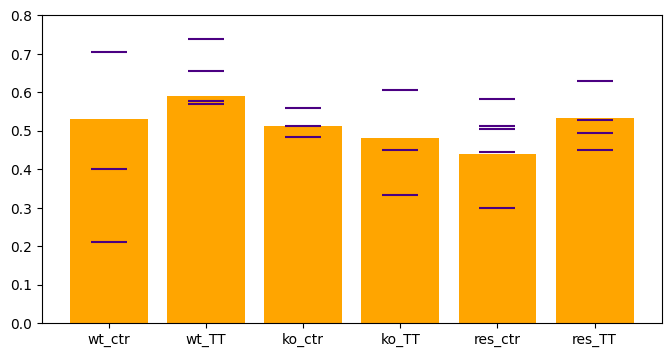

In [51]:
grouped_mean = df_clean.groupby(['slide_id', 'condition']).mean().groupby('condition').mean()[['cell_gfp_mean_positive',  'ki67_mean_positive', 	'ccasp_mean_positive']]

for marker in ['cell_gfp_mean']:#, 'ki67_mean', 'ccasp_mean']:

    plt.figure(figsize=(8,4))
    plt.bar(grouped_mean.index, grouped_mean.loc[:, 'cell_gfp_mean_positive'], color='orange')    
    plt.scatter([r[2] for r in slide_result], [r[1] for r in slide_result], marker='_', s=700, c='indigo')
    plt.ylim(0, .8)
    plt.savefig(os.path.join(figures_dir, f'percentage_{marker}+_category_method2.svg'), dpi=300)

    plt.savefig(os.path.join(figures_dir, f'percentage_{marker}+_category_simple_method2.svg'), dpi=300)


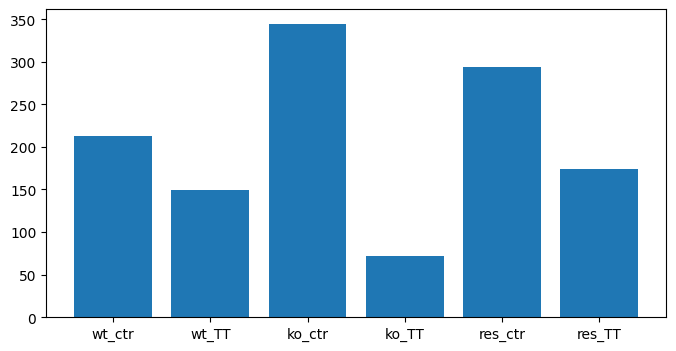

In [52]:
result = []
for s in conditions:
    
    dd = df_clean.loc[df_clean.condition == s]
    result.append([s, len(dd)])

plt.figure(figsize=(8,4))
plt.bar([r[0] for r in result], [r[1]/10**3 for r in result])
plt.savefig(os.path.join(figures_dir, 'absolute_n_cells_category_thousands.svg'), dpi=300)


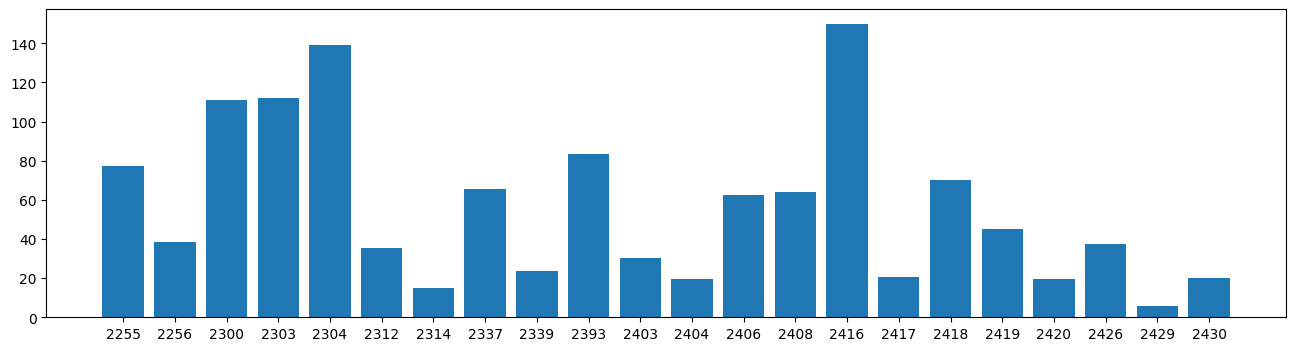

In [53]:
result = []
for s in sorted(df_clean.slide_id.unique()):
    
    dd = df_clean.loc[df_clean.slide_id == s]
    result.append([s, len(dd)])

plt.figure(figsize=(16,4))
plt.bar([r[0] for r in result], [r[1]/10**3 for r in result])
plt.savefig(os.path.join(figures_dir, 'absolute_n_cells_sample_thousands.svg'), dpi=300)


In [54]:
def MWU(cond1, cond2, measure, sample_size=None):

    s1 = df_clean.loc[df_clean.condition == cond1][measure]
    s2 = df_clean.loc[df_clean.condition == cond2][measure]

    if sample_size != None:
        s1 = sample(list(s1), sample_size)
        s2 = sample(list(s2), sample_size)
        
    
    _res = ss.mannwhitneyu(x=s1, y=s2)
    return {'r':_res[0], 'p': round(_res[1], 5)}

In [55]:
MWU('ko_TT', 'ko_ctr', 'ki67_mean', 10_000)

{'r': 50056472.0, 'p': 0.88998}

In [56]:
mwu_res = dict()

group1 = ['ko', 'res', 'wt']
group2 = ['TT', 'ctr']

for g in group1:
    
    mwu_res[g] = {}

    for meas in all_markers:
        meas = f'{meas}_mean'
        mwu_res[g][meas] = MWU(f'{g}_TT', f'{g}_ctr', meas, 1_000)

mwu_res

{'ko': {'ki67_mean': {'r': 496923.5, 'p': 0.81172},
  'slug_mean': {'r': 568984.5, 'p': 0.0},
  'ccasp_mean': {'r': 631834.0, 'p': 0.0},
  'c-myc_mean': {'r': 560710.5, 'p': 0.0},
  'cell_vim_mean': {'r': 333895.0, 'p': 0.0},
  'cell_ecad_mean': {'r': 381851.0, 'p': 0.0}},
 'res': {'ki67_mean': {'r': 693509.0, 'p': 0.0},
  'slug_mean': {'r': 578391.0, 'p': 0.0},
  'ccasp_mean': {'r': 481793.0, 'p': 0.15856},
  'c-myc_mean': {'r': 595227.5, 'p': 0.0},
  'cell_vim_mean': {'r': 404560.0, 'p': 0.0},
  'cell_ecad_mean': {'r': 432221.0, 'p': 0.0}},
 'wt': {'ki67_mean': {'r': 581727.0, 'p': 0.0},
  'slug_mean': {'r': 533369.0, 'p': 0.00976},
  'ccasp_mean': {'r': 592086.0, 'p': 0.0},
  'c-myc_mean': {'r': 624639.5, 'p': 0.0},
  'cell_vim_mean': {'r': 394347.5, 'p': 0.0},
  'cell_ecad_mean': {'r': 605411.0, 'p': 0.0}}}

In [57]:
kk_samples = []
for c in conditions:
    kk_samples.append(df_clean.loc[df_clean.condition == c]['ki67_mean'].values)

In [58]:
ss.kruskal(*kk_samples)

KruskalResult(statistic=79348.43724506724, pvalue=0.0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]
/projects/ag-bozek/stefano/pytorch_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:9638: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]
/projects/ag-bozek/stefano/pytorch_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:9638: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.08s/it]
/projects/ag-bo

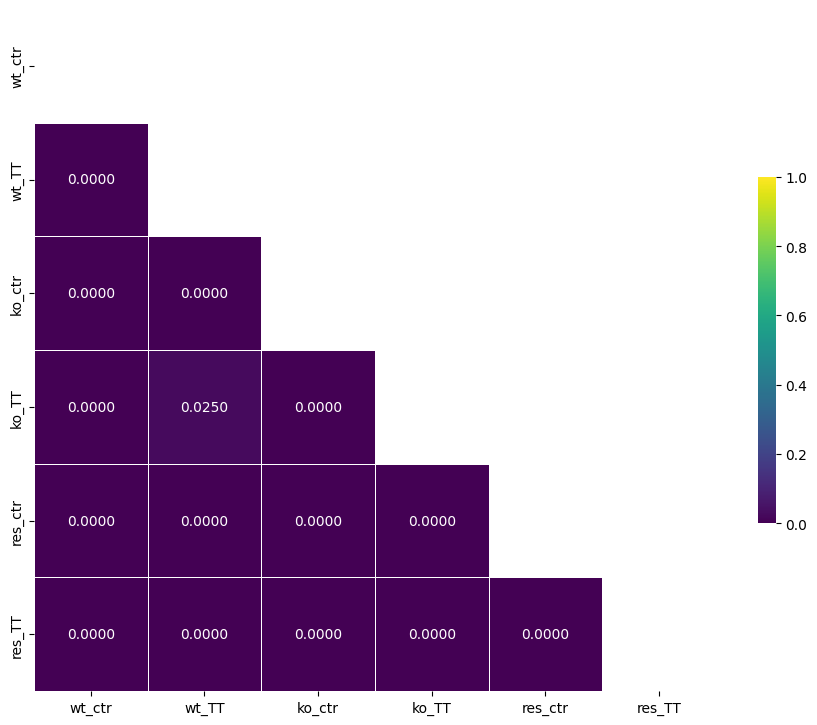

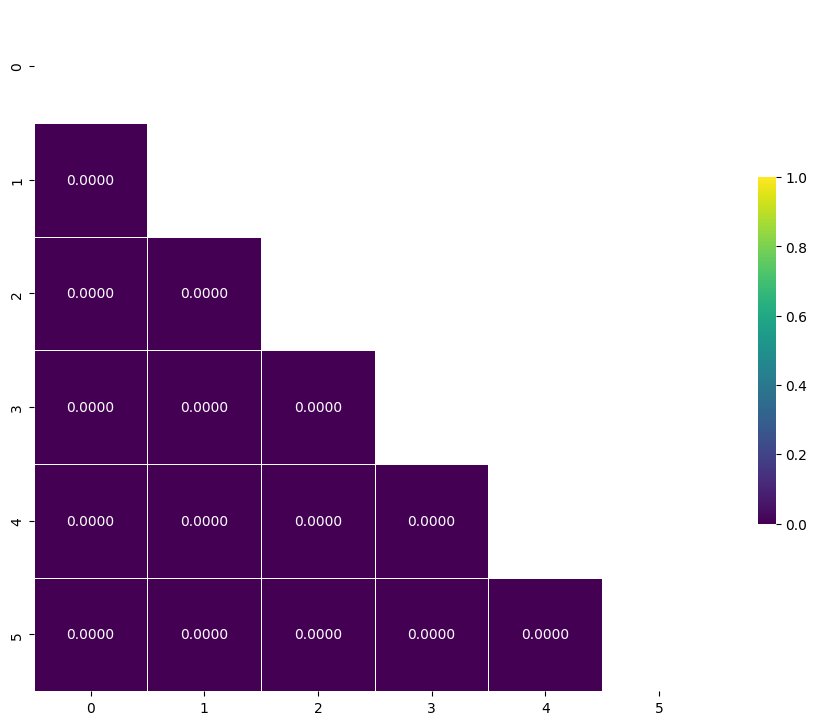

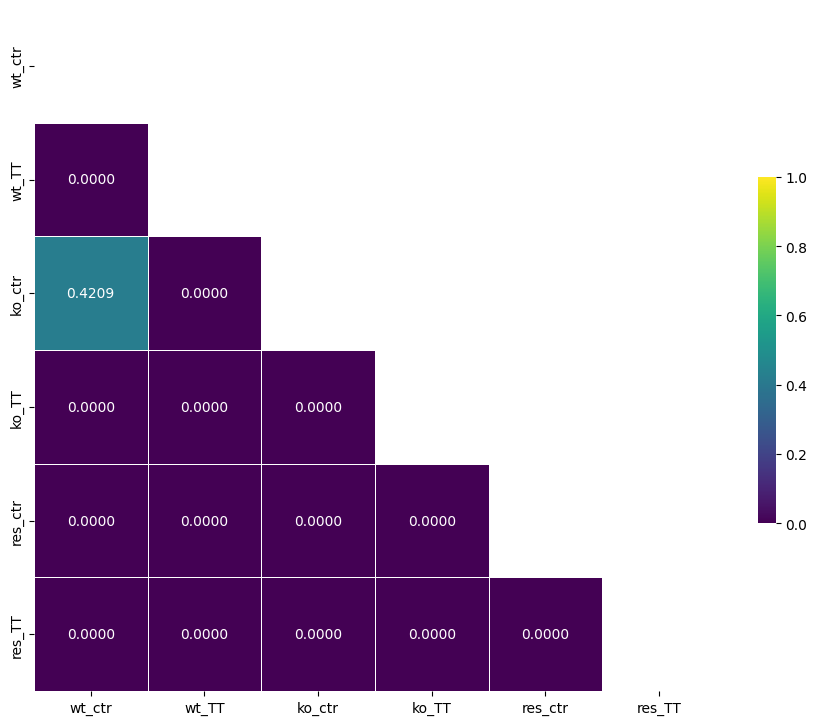

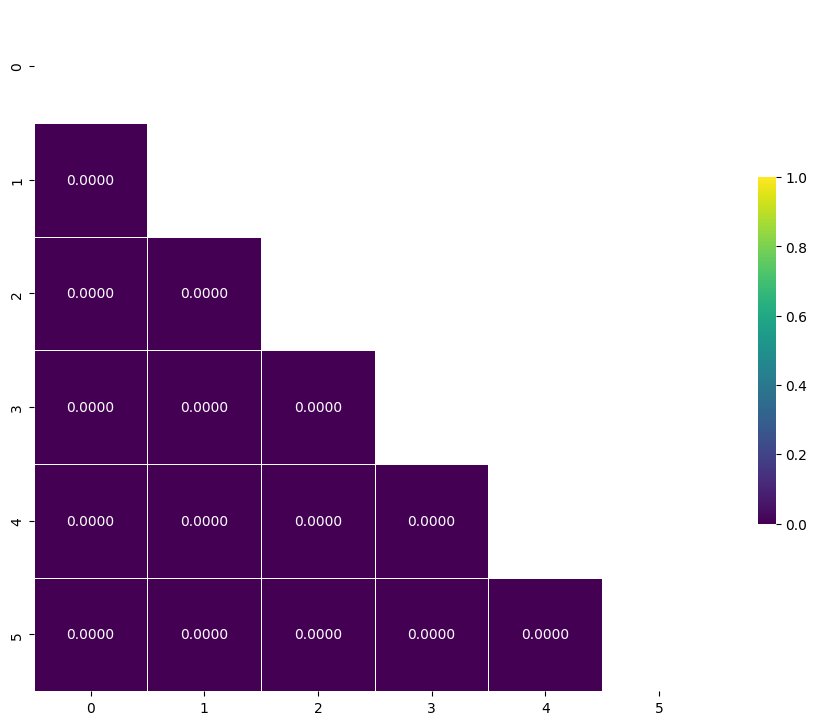

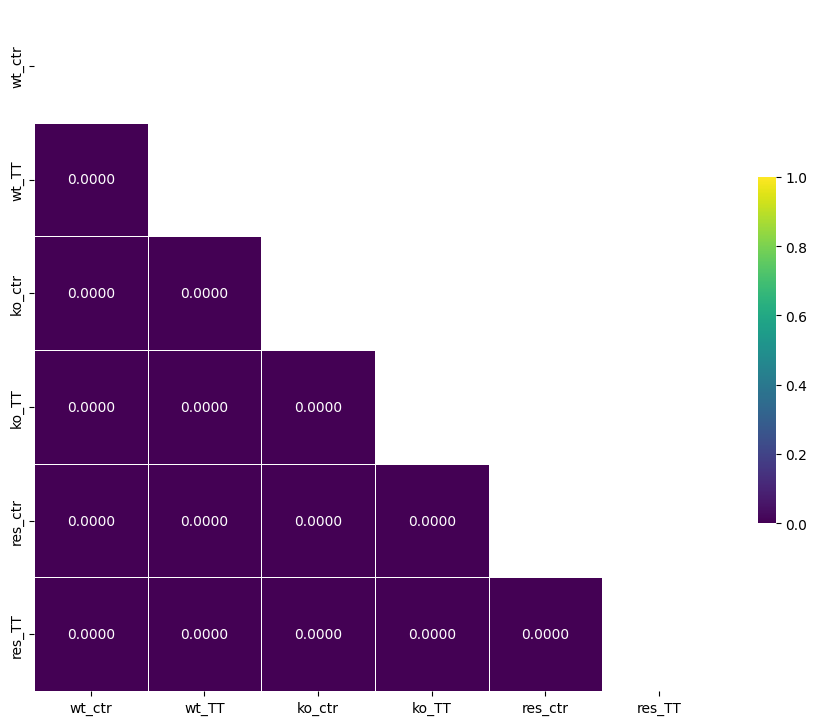

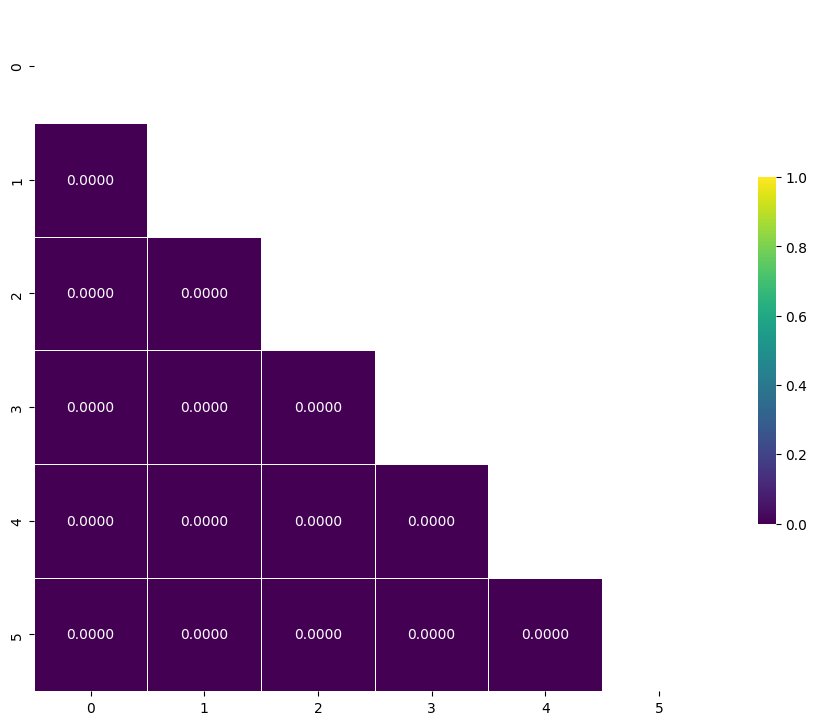

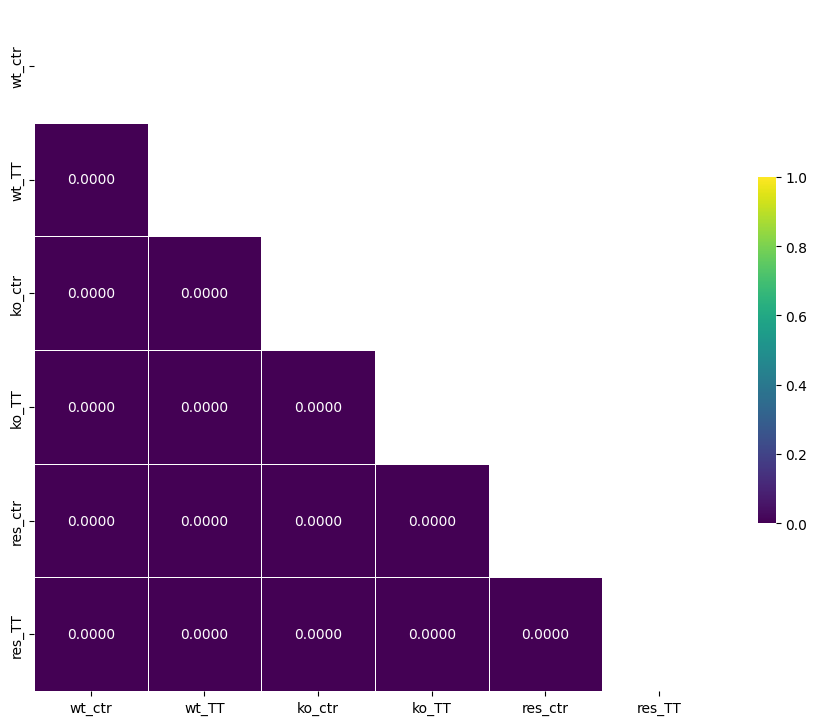

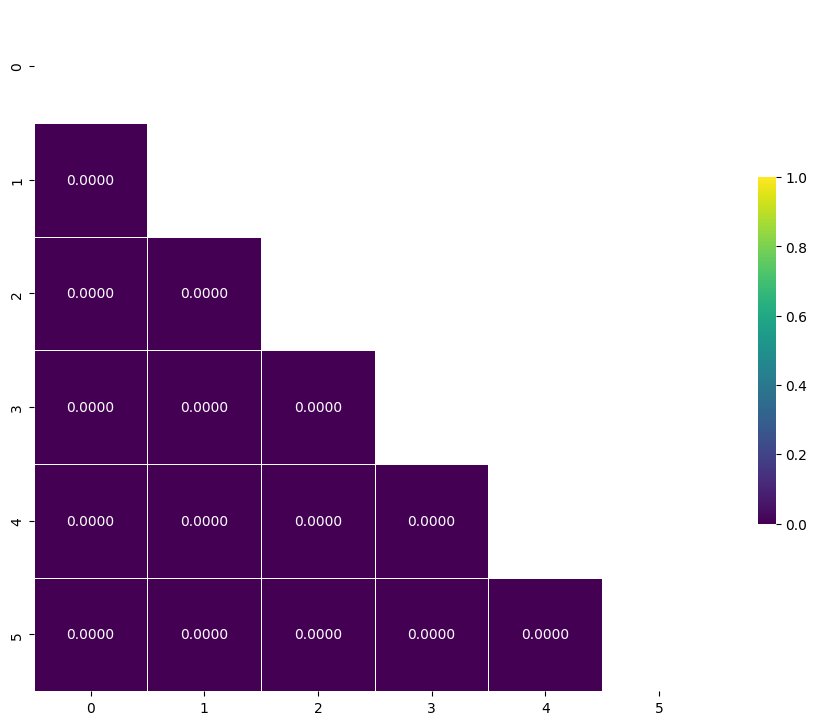

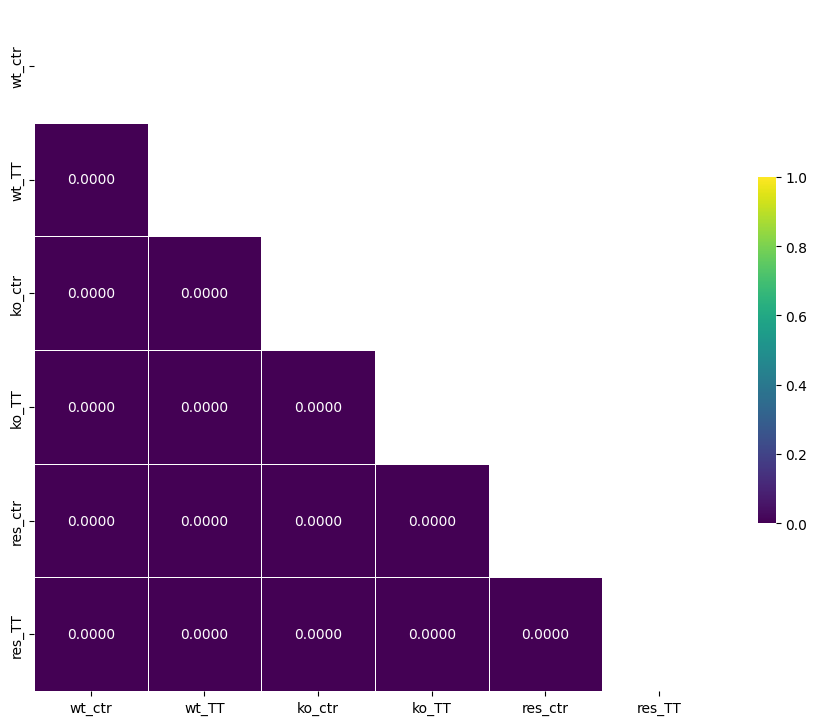

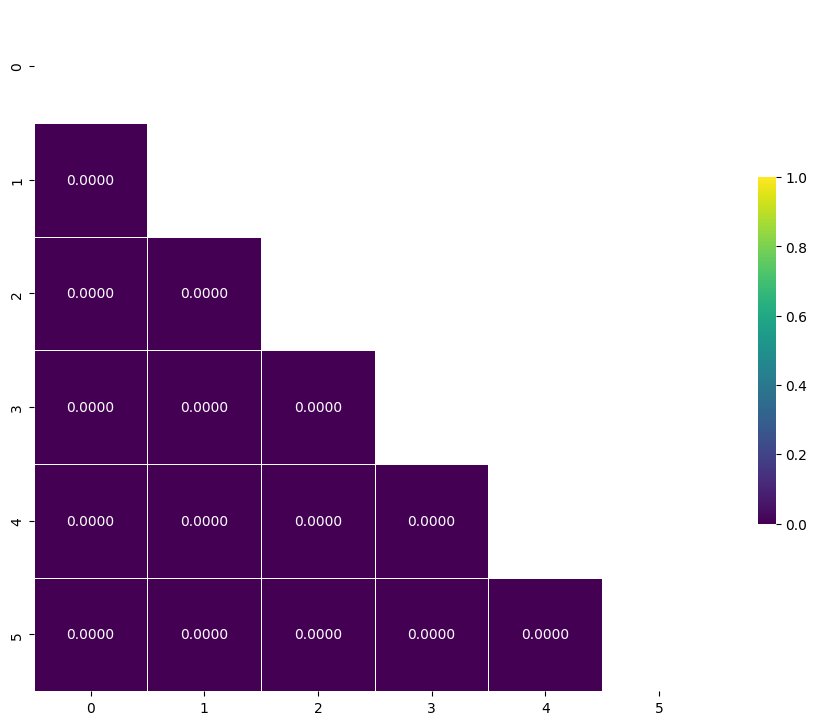

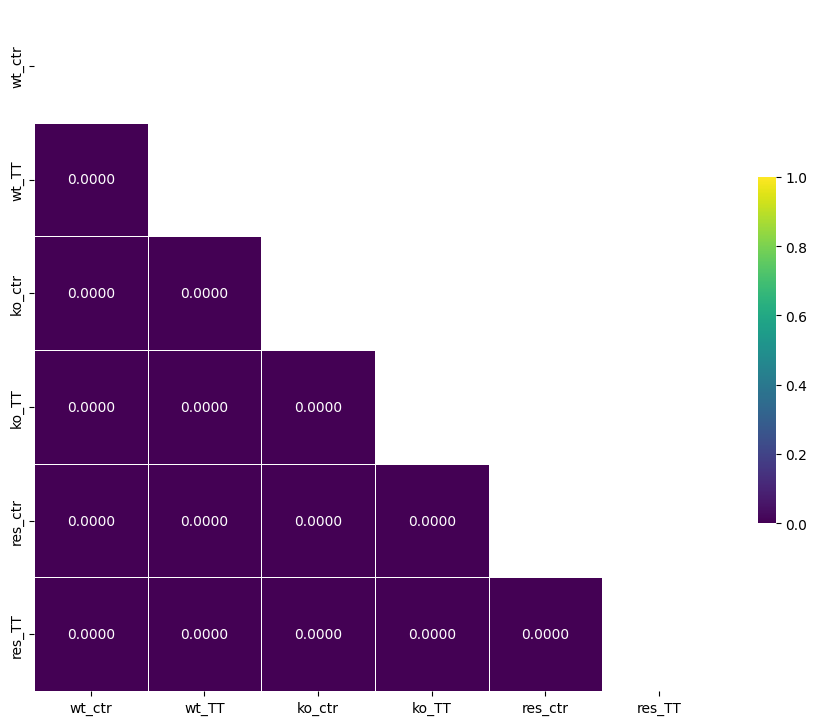

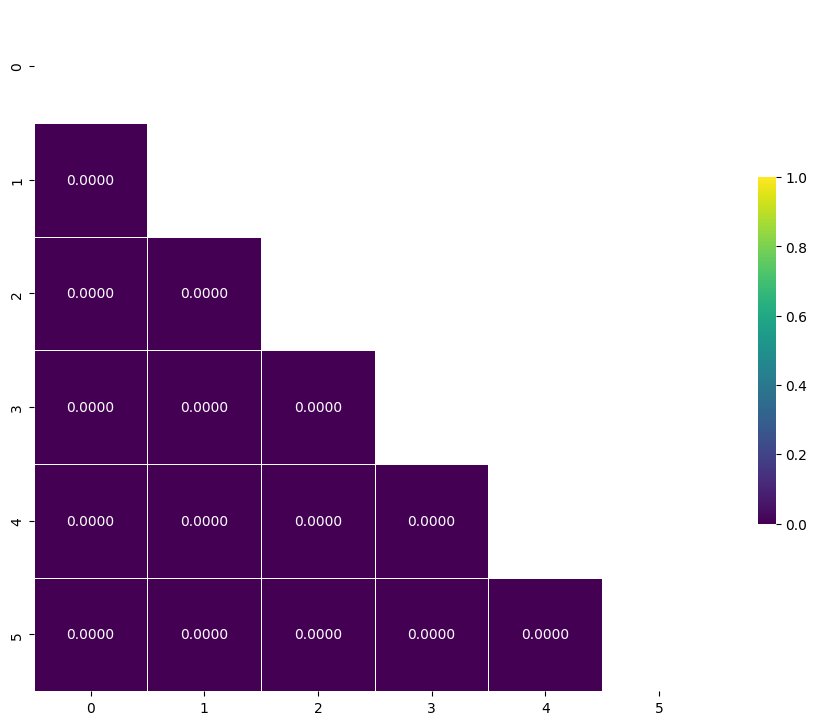

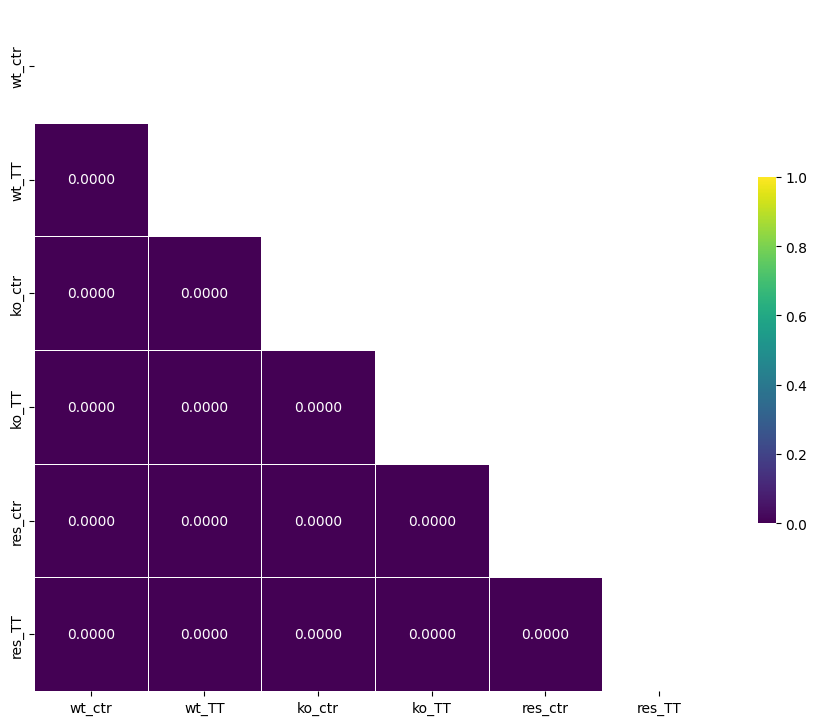

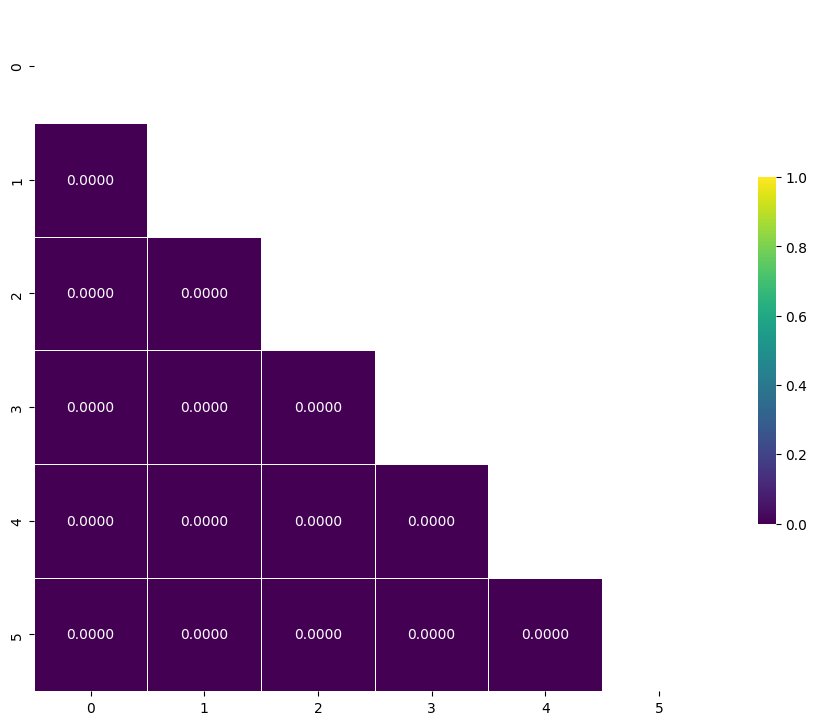

In [75]:
for measure in to_analyze:

    p_result = phd(
        a=df_clean,
        val_col=measure, 
        group_col='condition'
    )

    get_lower_tri_heatmap(p_result, f'dunn_result_single_{measure}.png')
    
    res_maps = []
    for i in tqdm(range(20)):
        res_maps.append(
            phd(
                a=df_clean.groupby('condition', observed=True).sample(50_000), 
                val_col=measure, 
                group_col='condition'
            )
        )
        #get_lower_tri_heatmap(dunn_res)
    pvals_res = pd.concat(res_maps).groupby(level=0, observed=True).apply(ss.combine_pvalues)
    get_lower_tri_heatmap(
        [p.pvalue for p in pvals_res],
        f'dunn_result_average_{measure}.png'
    )

In [63]:
aa = pd.concat(res_maps).groupby(level=0, observed=True).apply(ss.combine_pvalues)

In [71]:
np.array([a.pvalue for a in aa])

array([[1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 1.87114201e-129,
        1.25216644e-014, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.87114201e-129, 1.00000000e+000,
        3.44821553e-045, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.25216644e-014, 3.44821553e-045,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 1.00000000e+000]])

In [77]:
res_maps

[         wt_ctr          wt_TT        ko_ctr  ko_TT       res_ctr  \
 wt_ctr      1.0   0.000000e+00  0.000000e+00    0.0  0.000000e+00   
 wt_TT       0.0   1.000000e+00  0.000000e+00    0.0  2.312261e-80   
 ko_ctr      0.0   0.000000e+00  1.000000e+00    0.0  0.000000e+00   
 ko_TT       0.0   0.000000e+00  0.000000e+00    1.0  0.000000e+00   
 res_ctr     0.0   2.312261e-80  0.000000e+00    0.0  1.000000e+00   
 res_TT      0.0  1.059030e-274  3.747828e-69    0.0  0.000000e+00   
 
                 res_TT  
 wt_ctr    0.000000e+00  
 wt_TT    1.059030e-274  
 ko_ctr    3.747828e-69  
 ko_TT     0.000000e+00  
 res_ctr   0.000000e+00  
 res_TT    1.000000e+00  ,
          wt_ctr          wt_TT        ko_ctr  ko_TT       res_ctr  \
 wt_ctr      1.0   0.000000e+00  0.000000e+00    0.0  0.000000e+00   
 wt_TT       0.0   1.000000e+00  0.000000e+00    0.0  1.255663e-75   
 ko_ctr      0.0   0.000000e+00  1.000000e+00    0.0  0.000000e+00   
 ko_TT       0.0   0.000000e+00  0.000000e+00